# Stage 2.3 — EDA relationships, correlations, and artifacts (Blocks E/F/G)


This notebook continues Stage 2 from sanitized + quality-labeled tables and focuses on directional relationships, grouped correlation screening, targeted validation plots, artifact review, and synthesized findings.


In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from garmin_analytics.eda import add_derived_features, build_eda_frames, load_daily_sanitized, load_quality
from garmin_analytics.eda.plots_common import maybe_savefig, repo_root

In [ ]:
SAVE_FIGS: bool = False
DPI: int = 150
FIG_FMT: str = 'png'

ROOT = repo_root(Path.cwd())
DAILY_PATH = ROOT / 'data/processed/daily_sanitized.parquet'
QUALITY_PATH = ROOT / 'data/processed/daily_quality.parquet'
SUSPICIOUS_PATH = ROOT / 'reports/suspicious_days.csv'
SUSPICIOUS_ARTIFACTS_PATH = ROOT / 'reports/suspicious_days_artifacts.csv'
FIG_DIR = ROOT / 'reports/figures/relationships'

print('Repo root:', ROOT)
print('Daily input:', DAILY_PATH)
print('Quality input:', QUALITY_PATH)
print('Suspicious input:', SUSPICIOUS_PATH)
print('Suspicious artifacts input:', SUSPICIOUS_ARTIFACTS_PATH)


Repo root: /Users/abatrakov/Documents/FUN/wearable-analytics
Daily input: /Users/abatrakov/Documents/FUN/wearable-analytics/data/processed/daily_sanitized.parquet
Quality input: /Users/abatrakov/Documents/FUN/wearable-analytics/data/processed/daily_quality.parquet
Suspicious input: /Users/abatrakov/Documents/FUN/wearable-analytics/reports/suspicious_days.csv
Suspicious artifacts input: /Users/abatrakov/Documents/FUN/wearable-analytics/reports/suspicious_days_artifacts.csv


In [3]:
daily_df = load_daily_sanitized(DAILY_PATH)
quality_df = load_quality(QUALITY_PATH)
frames = build_eda_frames(daily_df, quality_df)


def _sanitize_stress_level_range_base(frame: pd.DataFrame, *, lo: float = 0.0, hi: float = 100.0) -> pd.DataFrame:
    """Notebook-global cleanup for stress-level sentinels (e.g., -2)."""
    out = frame.copy()
    for col in out.columns:
        if ('averageStressLevel' in str(col)) or ('avgSleepStress' in str(col)):
            s = pd.to_numeric(out[col], errors='coerce')
            out[col] = s.where((s >= lo) & (s <= hi))
    return out


df_all = _sanitize_stress_level_range_base(add_derived_features(frames['df_all']))
df_strict = _sanitize_stress_level_range_base(add_derived_features(frames['df_strict']))
df_sleep = _sanitize_stress_level_range_base(add_derived_features(frames['df_sleep']))

suspicious_days = pd.read_csv(SUSPICIOUS_PATH) if SUSPICIOUS_PATH.exists() else pd.DataFrame()
suspicious_days_artifacts = pd.read_csv(SUSPICIOUS_ARTIFACTS_PATH) if SUSPICIOUS_ARTIFACTS_PATH.exists() else pd.DataFrame()

pd.DataFrame([
    {'slice': 'df_all', 'rows': len(df_all), 'date_min': pd.to_datetime(df_all['calendarDate']).min(), 'date_max': pd.to_datetime(df_all['calendarDate']).max()},
    {'slice': 'df_strict', 'rows': len(df_strict), 'date_min': pd.to_datetime(df_strict['calendarDate']).min(), 'date_max': pd.to_datetime(df_strict['calendarDate']).max()},
    {'slice': 'df_sleep', 'rows': len(df_sleep), 'date_min': pd.to_datetime(df_sleep['calendarDate']).min(), 'date_max': pd.to_datetime(df_sleep['calendarDate']).max()},
])



slice  rows   date_min   date_max
0     df_all   580 2023-05-26 2026-02-05
1  df_strict   525 2023-05-26 2026-02-05
2   df_sleep   474 2023-05-27 2026-02-05

In [4]:
def _sleep_score_bucket_garmin(score):
    if pd.isna(score):
        return 'unknown'
    score = float(score)
    if score < 60:
        return 'poor'
    if score < 80:
        return 'fair'
    if score < 90:
        return 'good'
    return 'excellent'


def _ensure_step_length(frame: pd.DataFrame, *, min_steps: int = 1000) -> pd.DataFrame:
    out = frame.copy()
    if {'totalSteps', 'totalDistanceMeters'}.issubset(out.columns):
        steps = pd.to_numeric(out['totalSteps'], errors='coerce')
        dist = pd.to_numeric(out['totalDistanceMeters'], errors='coerce')
        out['step_length_m'] = np.where(steps >= min_steps, dist / steps, np.nan)
    return out


def _ensure_activity_duration_hours(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    if 'activeSeconds' in out.columns and 'active_hours' not in out.columns:
        out['active_hours'] = pd.to_numeric(out['activeSeconds'], errors='coerce') / 3600.0
    if 'highlyActiveSeconds' in out.columns:
        out['highly_active_hours'] = pd.to_numeric(out['highlyActiveSeconds'], errors='coerce') / 3600.0
    return out


def _ensure_bb_net(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    charged_cols = [c for c in ['bodyBattery_chargedValue', 'bodyBatteryChargedValue'] if c in out.columns]
    drained_cols = [c for c in ['bodyBattery_drainedValue', 'bodyBatteryDrainedValue'] if c in out.columns]
    if charged_cols and drained_cols:
        out['bb_net_balance'] = (
            pd.to_numeric(out[charged_cols[0]], errors='coerce')
            - pd.to_numeric(out[drained_cols[0]], errors='coerce')
        )
    return out


df_strict_d = _ensure_bb_net(_ensure_activity_duration_hours(_ensure_step_length(df_strict, min_steps=1000)))
df_sleep_d = _ensure_bb_net(_ensure_activity_duration_hours(_ensure_step_length(df_sleep, min_steps=1000)))
if 'sleepOverallScore' in df_sleep_d.columns:
    df_sleep_d['sleep_quality_bucket_garmin'] = pd.to_numeric(df_sleep_d['sleepOverallScore'], errors='coerce').apply(_sleep_score_bucket_garmin)

metric_roster = pd.DataFrame([
    {'group': 'activity', 'metric': 'totalSteps', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'activity', 'metric': 'step_length_m', 'slice': 'df_strict_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'activity', 'metric': 'active_hours', 'slice': 'df_strict_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'activity', 'metric': 'highly_active_hours', 'slice': 'df_strict_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'activity', 'metric': 'floorsAscendedInMeters', 'slice': 'df_strict', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'stress', 'metric': 'allDayStress_TOTAL_averageStressLevel', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'stress', 'metric': 'allDayStress_AWAKE_averageStressLevel', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'stress', 'metric': 'allDayStress_ASLEEP_averageStressLevel', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'stress', 'metric': 'stress_hours', 'slice': 'df_strict', 'role': 'distribution+artifact-diagnostic', 'priority': 'supporting'},
    {'group': 'heart', 'metric': 'restingHeartRate', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'heart', 'metric': 'minHeartRate', 'slice': 'df_strict', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'heart', 'metric': 'maxHeartRate', 'slice': 'df_strict', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'body_battery', 'metric': 'bodyBatteryHighest', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'body_battery', 'metric': 'bodyBatteryLowest', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'body_battery', 'metric': 'bodyBattery_chargedValue', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'body_battery', 'metric': 'bodyBattery_drainedValue', 'slice': 'df_strict', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'body_battery', 'metric': 'bb_net_balance', 'slice': 'df_strict_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'sleep_total_hours', 'slice': 'df_sleep_d', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'sleepOverallScore', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'sleepQualityScore', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'sleepDurationScore', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'sleepRecoveryScore', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'avgSleepStress', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'core'},
    {'group': 'sleep', 'metric': 'averageRespiration', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'lowestRespiration', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'highestRespiration', 'slice': 'df_sleep', 'role': 'distribution', 'priority': 'supporting'},
    {'group': 'sleep', 'metric': 'averageSpo2Value / lowestSpo2Value', 'slice': 'df_sleep', 'role': 'distribution+relationship', 'priority': 'supporting'},
    {'group': 'artifact_diagnostic', 'metric': 'stressTotalDurationSeconds', 'slice': 'df_all', 'role': 'artifact-diagnostic', 'priority': 'core'},
    {'group': 'artifact_diagnostic', 'metric': 'durationInMilliseconds', 'slice': 'df_all', 'role': 'artifact-diagnostic', 'priority': 'core'},
    {'group': 'artifact_diagnostic', 'metric': 'has_* flags + corrupted_stress_only_day', 'slice': 'df_all', 'role': 'artifact-diagnostic', 'priority': 'core'},
])

metric_roster


group                                   metric        slice  \
0              activity                               totalSteps    df_strict   
1              activity                            step_length_m  df_strict_d   
2              activity                             active_hours  df_strict_d   
3              activity                      highly_active_hours  df_strict_d   
4              activity                   floorsAscendedInMeters    df_strict   
5                stress    allDayStress_TOTAL_averageStressLevel    df_strict   
6                stress    allDayStress_AWAKE_averageStressLevel    df_strict   
7                stress   allDayStress_ASLEEP_averageStressLevel     df_sleep   
8                stress                             stress_hours    df_strict   
9                 heart                         restingHeartRate    df_strict   
10                heart                             minHeartRate    df_strict   
11                heart                             maxHeartRate    df_strict   
12         body_battery                       bodyBatteryHighest    df_strict   
13         body_battery                        bodyBatteryLowest    df_strict   
14         body_battery                 bodyBattery_chargedValue    df_strict   
15         body_battery                 bodyBattery_drainedValue    df_strict   
16         body_battery                           bb_net_balance  df_strict_d   
17                sleep                        sleep_total_hours   df_sleep_d   
18                sleep                        sleepOverallScore     df_sleep   
19                sleep                        sleepQualityScore     df_sleep   
20                sleep                       sleepDurationScore     df_sleep   
21                sleep                       sleepRecoveryScore     df_sleep   
22                sleep                           avgSleepStress     df_sleep   
23                sleep                       averageRespiration     df_sleep   
24                sleep                        lowestRespiration     df_sleep   
25                sleep                       highestRespiration     df_sleep   
26                sleep       averageSpo2Value / lowestSpo2Value     df_sleep   
27  artifact_diagnostic               stressTotalDurationSeconds       df_all   
28  artifact_diagnostic                   durationInMilliseconds       df_all   
29  artifact_diagnostic  has_* flags + corrupted_stress_only_day       df_all   

                                role    priority  
0          distribution+relationship        core  
1          distribution+relationship        core  
2          distribution+relationship        core  
3          distribution+relationship        core  
4                       distribution  supporting  
5          distribution+relationship        core  
6          distribution+relationship        core  
7          distribution+relationship        core  
8   distribution+artifact-diagnostic  supporting  
9          distribution+relationship        core  
10                      distribution  supporting  
11                      distribution  supporting  
12         distribution+relationship        core  
13         distribution+relationship        core  
14         distribution+relationship        core  
15         distribution+relationship        core  
16         distribution+relationship        core  
17         distribution+relationship        core  
18         distribution+relationship        core  
19                      distribution  supporting  
20                      distribution  supporting  
21         distribution+relationship        core  
22         distribution+relationship        core  
23                      distribution  supporting  
24                      distribution  supporting  
25                      distribution  supporting  
26         distribution+relationship  supporting  
27               artifact-diagnostic        core  
28               artifact-d

## 1. Block E — Relationships / interactions

Question: **Which metric relationships are strong, interpretable, and worth keeping in the final project story?**

This notebook prioritizes **temporal coherence** over raw quantity of plots:
- same-day descriptive links (`D -> D`)
- daytime load/stress carried into the following night (`D -> D+1 sleep`)
- sleep-internal structure used to interpret Garmin scores
- grouped correlation matrices used only as screening / triage
- explicit targeted validation plots for the strongest matrix candidates


### 1.1 Relationship helpers and alignment setup

Relationship plots use compact scatter + **quantile-bin summaries** (median/mean + IQR) to keep noisy point clouds readable.

**Alignment conventions (important):**
- **Same-day (`D -> D`)**: `sleep(D)` and daytime metrics stored on the same `calendarDate` row (sleep happened at the start of that day, then daytime activity/stress follows).
- **Day -> next-night (`D -> D+1`)**: daytime metrics on day `D` aligned to **next sleep row** (`sleep(D+1)`) to test hypotheses like `day stress -> next-night sleep quality`.
- Correlation matrices are used as a **screening layer only**. Only observations that remain interpretable in direct pair plots are carried into final findings.


In [5]:
def _safe_corr(x: pd.Series, y: pd.Series, *, method: str = 'pearson') -> float | None:
    tmp = pd.concat([pd.to_numeric(x, errors='coerce'), pd.to_numeric(y, errors='coerce')], axis=1).dropna()
    if len(tmp) < 3:
        return None
    return float(tmp.iloc[:, 0].corr(tmp.iloc[:, 1], method=method))


def _ensure_sleep_stage_hours(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    stage_map = {
        'deepSleepSeconds': 'deepSleepHours',
        'lightSleepSeconds': 'lightSleepHours',
        'remSleepSeconds': 'remSleepHours',
        'awakeSleepSeconds': 'awakeSleepHours',
        'unmeasurableSeconds': 'unmeasurableSleepHours',
    }
    for sec_col, hr_col in stage_map.items():
        if sec_col in out.columns and hr_col not in out.columns:
            out[hr_col] = pd.to_numeric(out[sec_col], errors='coerce') / 3600.0
    return out


def _row_garmin_offset_hours(frame: pd.DataFrame) -> pd.Series:
    out = pd.Series(np.nan, index=frame.index, dtype='float64')
    for gmt_col, local_col in [('wellnessStartTimeGmt', 'wellnessStartTimeLocal'), ('wellnessEndTimeGmt', 'wellnessEndTimeLocal')]:
        if gmt_col in frame.columns and local_col in frame.columns:
            gmt_ts = pd.to_datetime(frame[gmt_col], errors='coerce')
            local_ts = pd.to_datetime(frame[local_col], errors='coerce')
            delta_h = (local_ts - gmt_ts).dt.total_seconds() / 3600.0
            out = out.where(~out.isna(), delta_h)
    return out


def _ensure_sleep_local_time_features(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    if 'sleepStartTimestampGMT' in out.columns and 'sleep_start_hour_local' not in out.columns:
        sleep_start_utc = pd.to_datetime(pd.to_numeric(out['sleepStartTimestampGMT'], errors='coerce'), unit='s', utc=True, errors='coerce')
        offset_h = _row_garmin_offset_hours(out)
        # Fallback to local machine timezone conversion only if Garmin per-row offset is unavailable.
        local_dt = sleep_start_utc.copy()
        mask = offset_h.notna() & sleep_start_utc.notna()
        if mask.any():
            local_dt.loc[mask] = sleep_start_utc.loc[mask] + pd.to_timedelta(offset_h.loc[mask], unit='h')
        out['sleep_start_hour_local'] = (
            local_dt.dt.hour.astype('float64')
            + local_dt.dt.minute.astype('float64') / 60.0
            + local_dt.dt.second.astype('float64') / 3600.0
        )
    return out




def _ensure_sleep_start_hour_wrapped(
    frame: pd.DataFrame,
    *,
    src_col: str = 'sleep_start_hour_local',
    dst_col: str = 'sleep_start_hour_local_wrapped',
    wrap_at: float = 18.0,
) -> pd.DataFrame:
    out = frame.copy()
    if src_col not in out.columns:
        return out
    h = pd.to_numeric(out[src_col], errors='coerce')
    out[dst_col] = np.where(h >= wrap_at, h - 24.0, h)
    return out


def _prepare_day_to_next_sleep(day_frame: pd.DataFrame, sleep_frame: pd.DataFrame, next_sleep_cols: list[str]) -> pd.DataFrame:
    day = day_frame.copy()
    day['calendarDate'] = pd.to_datetime(day['calendarDate'], errors='coerce').dt.normalize()
    day = day.dropna(subset=['calendarDate'])

    sleep = sleep_frame.copy()
    sleep['calendarDate'] = pd.to_datetime(sleep['calendarDate'], errors='coerce').dt.normalize()
    sleep = sleep.dropna(subset=['calendarDate'])
    keep_sleep = ['calendarDate'] + [c for c in next_sleep_cols if c in sleep.columns]
    sleep = sleep[keep_sleep].copy()
    sleep['day_date'] = sleep['calendarDate'] - pd.Timedelta(days=1)
    rename_map = {c: f'nextsleep_{c}' for c in sleep.columns if c not in {'calendarDate', 'day_date'}}
    sleep = sleep.rename(columns=rename_map)

    merged = day.merge(sleep.drop(columns=['calendarDate']), left_on='calendarDate', right_on='day_date', how='left')
    return merged


def _quantile_binned_summary(df: pd.DataFrame, xcol: str, ycol: str, q: int = 10) -> pd.DataFrame:
    tmp = df[[xcol, ycol]].copy()
    tmp[xcol] = pd.to_numeric(tmp[xcol], errors='coerce')
    tmp[ycol] = pd.to_numeric(tmp[ycol], errors='coerce')
    tmp = tmp.dropna()
    if len(tmp) < max(15, q * 2):
        return pd.DataFrame()
    try:
        q_eff = int(min(q, max(2, tmp[xcol].nunique())))
        bins = pd.qcut(tmp[xcol], q=q_eff, duplicates='drop')
    except Exception:
        return pd.DataFrame()

    g = tmp.groupby(bins, observed=True)
    out = pd.DataFrame({
        'x_median': g[xcol].median(),
        'y_median': g[ycol].median(),
        'y_mean': g[ycol].mean(),
        'y_q25': g[ycol].quantile(0.25),
        'y_q75': g[ycol].quantile(0.75),
        'n': g[ycol].size(),
    }).reset_index(drop=True)
    return out


def _format_clock_axis(ax, *, axis: str = 'x') -> None:
    if axis not in {'x', 'y'}:
        return
    lo, hi = (ax.get_xlim() if axis == 'x' else ax.get_ylim())
    lo_i = int(np.floor(lo))
    hi_i = int(np.ceil(hi))
    span = max(1, hi_i - lo_i)
    step = 1 if span <= 14 else 2
    ticks = np.arange(lo_i, hi_i + 1, step)
    labels = [f"{int(t % 24):02d}" for t in ticks]
    if axis == 'x':
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels)
    else:
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)


def plot_relationship(
    frame: pd.DataFrame,
    xcol: str,
    ycol: str,
    *,
    title: str,
    xlabel: str | None = None,
    ylabel: str | None = None,
    fig_name: str | None = None,
    max_points: int = 1200,
    clock_axis_x: bool = False,
    clock_axis_y: bool = False,
):
    if xcol not in frame.columns or ycol not in frame.columns:
        print(f'Skip relationship: missing {xcol} or {ycol}')
        return
    tmp = frame[[xcol, ycol]].copy()
    tmp[xcol] = pd.to_numeric(tmp[xcol], errors='coerce')
    tmp[ycol] = pd.to_numeric(tmp[ycol], errors='coerce')
    tmp = tmp.dropna()
    if tmp.empty:
        print(f'Skip relationship: no data for {xcol} vs {ycol}')
        return

    tmp_plot = tmp.sample(max_points, random_state=42) if len(tmp) > max_points else tmp
    binned = _quantile_binned_summary(tmp, xcol, ycol, q=10)
    corr = _safe_corr(tmp[xcol], tmp[ycol], method='pearson')

    fig, axes = plt.subplots(1, 2, figsize=(13, 4), gridspec_kw={'width_ratios': [3, 2]})
    ax_sc, ax_bin = axes

    ax_sc.scatter(tmp_plot[xcol], tmp_plot[ycol], s=16, alpha=0.22, edgecolors='none', color='#1f77b4')
    ax_sc.set_title(title)
    ax_sc.set_xlabel(xlabel or xcol)
    ax_sc.set_ylabel(ylabel or ycol)
    ax_sc.grid(alpha=0.2)
    if corr is not None and np.isfinite(corr):
        ax_sc.text(
            0.02, 0.98, f'Pearson r = {corr:.2f} (n={len(tmp)})', transform=ax_sc.transAxes,
            ha='left', va='top', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.75, edgecolor='none'),
        )

    if not binned.empty:
        b = binned.sort_values('x_median')
        ax_bin.fill_between(b['x_median'], b['y_q25'], b['y_q75'], color='#d62728', alpha=0.15, label='binned IQR (q25-q75)')
        ax_bin.plot(b['x_median'], b['y_median'], marker='o', lw=1.8, color='#d62728', label='binned median')
        ax_bin.scatter(b['x_median'], b['y_mean'], marker='x', s=36, color='#9467bd', label='binned mean')
        for _, r in b.iterrows():
            ax_bin.annotate(str(int(r['n'])), (r['x_median'], r['y_median']), textcoords='offset points', xytext=(0, 5), ha='center', fontsize=7, color='#444')
        ax_bin.legend(loc='best', fontsize=8)
    else:
        ax_bin.text(0.5, 0.5, 'Binned summary unavailable', ha='center', va='center', transform=ax_bin.transAxes)
    ax_bin.set_title('quantile-bin summary')
    ax_bin.set_xlabel(xlabel or xcol)
    ax_bin.set_ylabel(ylabel or ycol)
    ax_bin.grid(alpha=0.2)

    if clock_axis_x:
        _format_clock_axis(ax_sc, axis='x')
        _format_clock_axis(ax_bin, axis='x')
    if clock_axis_y:
        _format_clock_axis(ax_sc, axis='y')
        _format_clock_axis(ax_bin, axis='y')

    fig.tight_layout()
    if fig_name is not None:
        maybe_savefig(fig, fig_name, save_figs=SAVE_FIGS, fig_dir=FIG_DIR, dpi=DPI, fmt=FIG_FMT)
    plt.show()
    plt.close(fig)


def _pairwise_corr_block(frame: pd.DataFrame, row_cols: list[str], col_cols: list[str], *, method: str = 'spearman'):
    rows = [c for c in row_cols if c in frame.columns]
    cols = [c for c in col_cols if c in frame.columns]
    if not rows or not cols:
        return pd.DataFrame(), pd.DataFrame()
    corr = pd.DataFrame(index=rows, columns=cols, dtype='float64')
    nobs = pd.DataFrame(index=rows, columns=cols, dtype='float64')
    for r in rows:
        for c in cols:
            x = pd.to_numeric(frame[r], errors='coerce')
            y = pd.to_numeric(frame[c], errors='coerce')
            tmp = pd.concat({'x': x, 'y': y}, axis=1).dropna()
            nobs.loc[r, c] = len(tmp)
            if len(tmp) >= 3:
                corr.loc[r, c] = tmp['x'].corr(tmp['y'], method=method)
            else:
                corr.loc[r, c] = np.nan
    return corr, nobs


def plot_corr_block(
    frame: pd.DataFrame,
    row_cols: list[str],
    col_cols: list[str],
    *,
    title: str,
    method: str = 'spearman',
    fig_name: str | None = None,
    min_n: int = 40,
    mask_low_n: bool = True,
):
    corr, nobs = _pairwise_corr_block(frame, row_cols, col_cols, method=method)
    if corr.empty:
        print(f'Skip corr block: {title} (missing columns)')
        return

    fig, axes = plt.subplots(1, 2, figsize=(max(10, 0.8 * len(corr.columns) + 4), max(4.5, 0.45 * len(corr.index) + 2)), gridspec_kw={'width_ratios': [4, 1.3]})
    ax_hm, ax_n = axes
    arr_raw = corr.to_numpy(dtype=float)
    n_arr = nobs.to_numpy(dtype=float)
    arr = np.where(n_arr >= float(min_n), arr_raw, np.nan) if mask_low_n else arr_raw

    base_cmap = plt.get_cmap('coolwarm')
    # Matplotlib compatibility: some versions do not expose Colormap.copy().
    if hasattr(base_cmap, 'copy'):
        cmap = base_cmap.copy()
    else:
        cmap = plt.get_cmap('coolwarm', 256)
    cmap.set_bad(color='#d9d9d9')
    im = ax_hm.imshow(arr, aspect='auto', cmap=cmap, vmin=-1, vmax=1)

    n_tag = f', n≥{min_n}' if mask_low_n else ''
    ax_hm.set_title(f'{title} ({method}{n_tag})')
    ax_hm.set_xticks(range(len(corr.columns)))
    ax_hm.set_xticklabels(corr.columns, rotation=45, ha='right', fontsize=8)
    ax_hm.set_yticks(range(len(corr.index)))
    ax_hm.set_yticklabels(corr.index, fontsize=8)
    for r in range(arr.shape[0]):
        for c in range(arr.shape[1]):
            val = arr[r, c]
            if np.isfinite(val):
                ax_hm.text(c, r, f'{val:.2f}', ha='center', va='center', fontsize=7, color='white' if abs(val) > 0.5 else 'black')
            elif mask_low_n and np.isfinite(n_arr[r, c]) and n_arr[r, c] < min_n:
                ax_hm.text(c, r, '·', ha='center', va='center', fontsize=8, color='#555')

    cbar = fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('corr', rotation=90)

    # right panel: minimum/median pairwise n per row to judge reliability
    n_summary = pd.DataFrame({
        'n_min': nobs.min(axis=1, skipna=True),
        'n_med': nobs.median(axis=1, skipna=True),
    })
    y = np.arange(len(n_summary))
    ax_n.barh(y - 0.15, n_summary['n_min'].fillna(0), height=0.28, label='n_min', color='#8da0cb')
    ax_n.barh(y + 0.15, n_summary['n_med'].fillna(0), height=0.28, label='n_med', color='#66c2a5')
    if mask_low_n:
        ax_n.axvline(min_n, ls='--', lw=1.0, color='#444', label=f'n threshold ({min_n})')
    ax_n.set_yticks(y)
    ax_n.set_yticklabels([])
    ax_n.set_title('pairwise n')
    ax_n.grid(axis='x', alpha=0.2)
    ax_n.legend(fontsize=7, loc='best')

    fig.tight_layout()
    if fig_name is not None:
        maybe_savefig(fig, fig_name, save_figs=SAVE_FIGS, fig_dir=FIG_DIR, dpi=DPI, fmt=FIG_FMT)
    plt.show()
    plt.close(fig)


def _ensure_stress_context_features(frame: pd.DataFrame, context: str, *, prefix: str) -> pd.DataFrame:
    """Create readable aliases + hours/shares for Garmin allDayStress_<CONTEXT> fields."""
    out = frame.copy()
    base = f'allDayStress_{context}_'

    avg_col = base + 'averageStressLevel'
    if avg_col in out.columns:
        out[f'{prefix}AverageStressLevel'] = pd.to_numeric(out[avg_col], errors='coerce')

    duration_alias = {
        'activityDuration': f'{prefix}ActivityHours',
        'lowDuration': f'{prefix}LowStressHours',
        'mediumDuration': f'{prefix}MediumStressHours',
        'highDuration': f'{prefix}HighStressHours',
        'restDuration': f'{prefix}RestHours',
        'uncategorizedDuration': f'{prefix}UncatHours',
        'totalDuration': f'{prefix}MeasuredHours',
    }
    for raw_suffix, alias in duration_alias.items():
        raw_col = base + raw_suffix
        if raw_col in out.columns:
            out[alias] = pd.to_numeric(out[raw_col], errors='coerce') / 3600.0

    total_col = f'{prefix}MeasuredHours'
    if total_col in out.columns:
        total = pd.to_numeric(out[total_col], errors='coerce')
        for stem in ['Activity', 'LowStress', 'MediumStress', 'HighStress', 'Rest', 'Uncat']:
            hcol = f'{prefix}{stem}Hours'
            scol = f'{prefix}{stem}Share'
            if hcol in out.columns:
                numer = pd.to_numeric(out[hcol], errors='coerce')
                out[scol] = np.nan
                mask = total.notna() & numer.notna() & (total > 0)
                if mask.any():
                    out.loc[mask, scol] = numer.loc[mask] / total.loc[mask]
    return out


def _ensure_bodybattery_aliases(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    if 'bodyBattery_chargedValue' in out.columns and 'bodyBatteryCharged' not in out.columns:
        out['bodyBatteryCharged'] = pd.to_numeric(out['bodyBattery_chargedValue'], errors='coerce')
    if 'bodyBattery_drainedValue' in out.columns and 'bodyBatteryDrained' not in out.columns:
        out['bodyBatteryDrained'] = pd.to_numeric(out['bodyBattery_drainedValue'], errors='coerce')
    if 'bodyBatteryCharged' in out.columns and 'bodyBatteryDrained' in out.columns and 'bodyBatteryNetBalance' not in out.columns:
        out['bodyBatteryNetBalance'] = pd.to_numeric(out['bodyBatteryCharged'], errors='coerce') - pd.to_numeric(out['bodyBatteryDrained'], errors='coerce')
    return out


def _ensure_sleep_sensor_aliases(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    # Prefer explicit sleep-summary names if present, otherwise fallback to legacy names.
    if 'sleepSpo2Average' not in out.columns:
        if 'spo2SleepAverageSPO2' in out.columns:
            out['sleepSpo2Average'] = pd.to_numeric(out['spo2SleepAverageSPO2'], errors='coerce')
        elif 'averageSpo2Value' in out.columns:
            out['sleepSpo2Average'] = pd.to_numeric(out['averageSpo2Value'], errors='coerce')
    if 'sleepSpo2Lowest' not in out.columns:
        if 'spo2SleepLowestSPO2' in out.columns:
            out['sleepSpo2Lowest'] = pd.to_numeric(out['spo2SleepLowestSPO2'], errors='coerce')
        elif 'lowestSpo2Value' in out.columns:
            out['sleepSpo2Lowest'] = pd.to_numeric(out['lowestSpo2Value'], errors='coerce')
    if 'sleepSpo2AverageHR' not in out.columns and 'spo2SleepAverageHR' in out.columns:
        out['sleepSpo2AverageHR'] = pd.to_numeric(out['spo2SleepAverageHR'], errors='coerce')

    for raw, alias in [
        ('averageRespiration', 'sleepRespirationAverage'),
        ('lowestRespiration', 'sleepRespirationLowest'),
        ('highestRespiration', 'sleepRespirationHighest'),
    ]:
        if alias not in out.columns and raw in out.columns:
            out[alias] = pd.to_numeric(out[raw], errors='coerce')
    return out


def _sanitize_stress_level_range(frame: pd.DataFrame, *, lo: float = 0.0, hi: float = 100.0) -> pd.DataFrame:
    # Drop sentinel/invalid stress averages outside Garmin scale [0, 100].
    out = frame.copy()
    for col in out.columns:
        if ('averageStressLevel' in str(col)) or ('avgSleepStress' in str(col)):
            s = pd.to_numeric(out[col], errors='coerce')
            out[col] = s.where((s >= lo) & (s <= hi))
    return out


def _safe_display_any(obj):
    try:
        _safe_display(obj)  # defined earlier in notebook (cell 27)
    except Exception:
        print(obj.to_string(index=False) if hasattr(obj, 'to_string') else obj)


def _prepare_e_frames() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    strict = _ensure_bb_net(_ensure_activity_duration_hours(_ensure_step_length(df_strict, min_steps=1000)))
    sleep = _ensure_bb_net(_ensure_activity_duration_hours(_ensure_step_length(df_sleep, min_steps=1000)))
    strict = _ensure_bodybattery_aliases(strict)
    sleep = _ensure_bodybattery_aliases(sleep)
    strict = _ensure_stress_context_features(strict, 'AWAKE', prefix='awake')
    strict = _ensure_stress_context_features(strict, 'ASLEEP', prefix='sleep')  # may be partially available in strict rows with sleep
    strict = _ensure_stress_context_features(strict, 'TOTAL', prefix='total')
    strict = _sanitize_stress_level_range(strict)
    sleep = _ensure_stress_context_features(sleep, 'AWAKE', prefix='awake')
    sleep = _ensure_stress_context_features(sleep, 'ASLEEP', prefix='sleep')
    sleep = _ensure_stress_context_features(sleep, 'TOTAL', prefix='total')
    sleep = _ensure_sleep_stage_hours(sleep)
    sleep = _ensure_sleep_local_time_features(sleep)
    sleep = _ensure_sleep_start_hour_wrapped(sleep)
    sleep = _ensure_sleep_sensor_aliases(sleep)
    sleep = _sanitize_stress_level_range(sleep)
    if 'sleepOverallScore' in sleep.columns and 'sleep_quality_bucket_garmin' not in sleep.columns:
        sleep['sleep_quality_bucket_garmin'] = pd.to_numeric(sleep['sleepOverallScore'], errors='coerce').apply(_sleep_score_bucket_garmin)

    next_sleep_cols = [
        # sleep core / extended
        'sleep_total_hours', 'sleepOverallScore', 'sleepQualityScore', 'sleepDurationScore', 'sleepRecoveryScore',
        'sleep_start_hour_local', 'sleep_start_hour_local_wrapped', 'avgSleepStress', 'awakeSleepHours', 'deepSleepHours', 'lightSleepHours', 'remSleepHours', 'unmeasurableSleepHours',
        'sleepRespirationAverage', 'sleepRespirationLowest', 'sleepRespirationHighest',
        'sleepSpo2Average', 'sleepSpo2Lowest', 'sleepSpo2AverageHR',
        # ASLEEP stress alias layer
        'sleepAverageStressLevel', 'sleepActivityHours', 'sleepLowStressHours', 'sleepMediumStressHours', 'sleepHighStressHours', 'sleepRestHours', 'sleepUncatHours',
        'sleepActivityShare', 'sleepLowStressShare', 'sleepMediumStressShare', 'sleepHighStressShare', 'sleepRestShare', 'sleepUncatShare',
        # physiology overlap
        'restingHeartRate', 'currentDayRestingHeartRate',
    ]
    day_nextsleep = _prepare_day_to_next_sleep(strict, sleep, next_sleep_cols)
    day_nextsleep = _sanitize_stress_level_range(day_nextsleep)
    return strict, sleep, day_nextsleep


df_strict_e, df_sleep_e, df_day_nextsleep = _prepare_e_frames()






### 1.2 Sleep (morning) -> same-day daytime outcomes (`D -> D`)

These comparisons are time-aligned in the natural within-day order for this dataset: sleep at the start of day `D`, then daytime activity/stress during the same `calendarDate`.


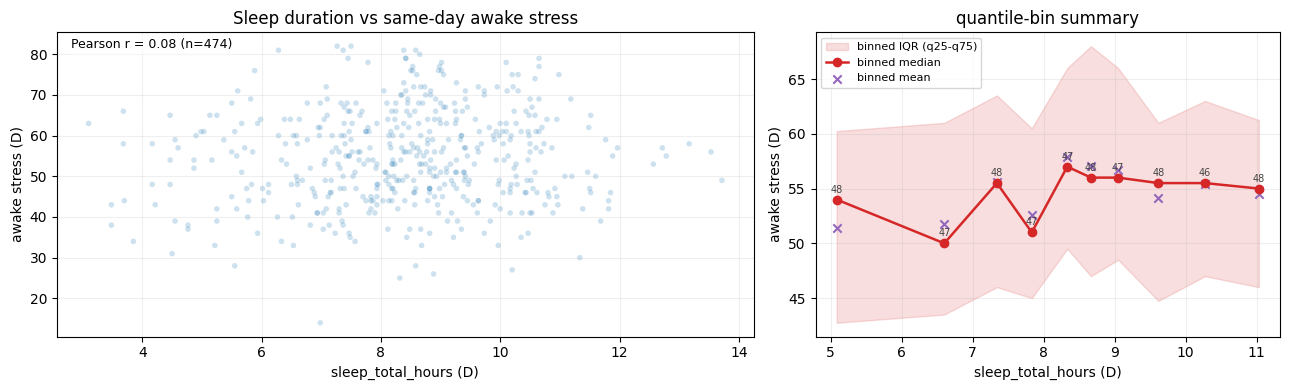

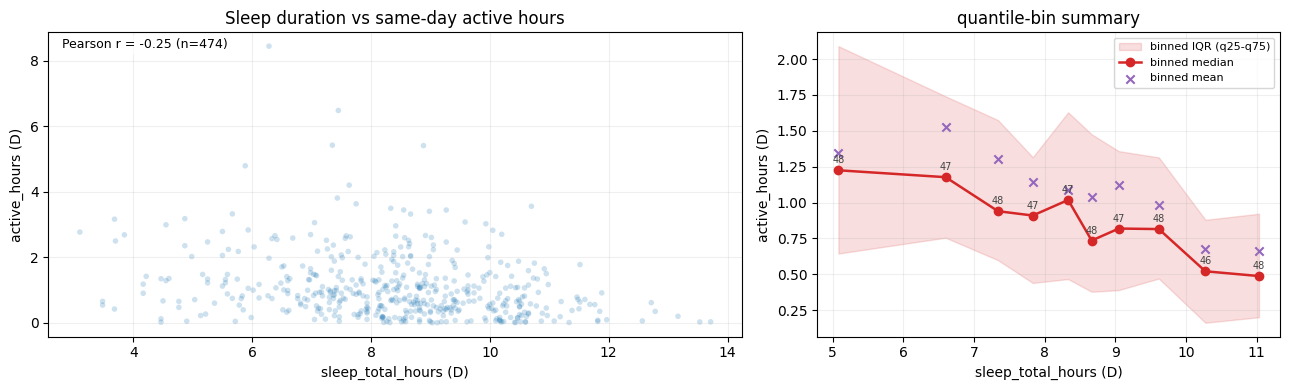

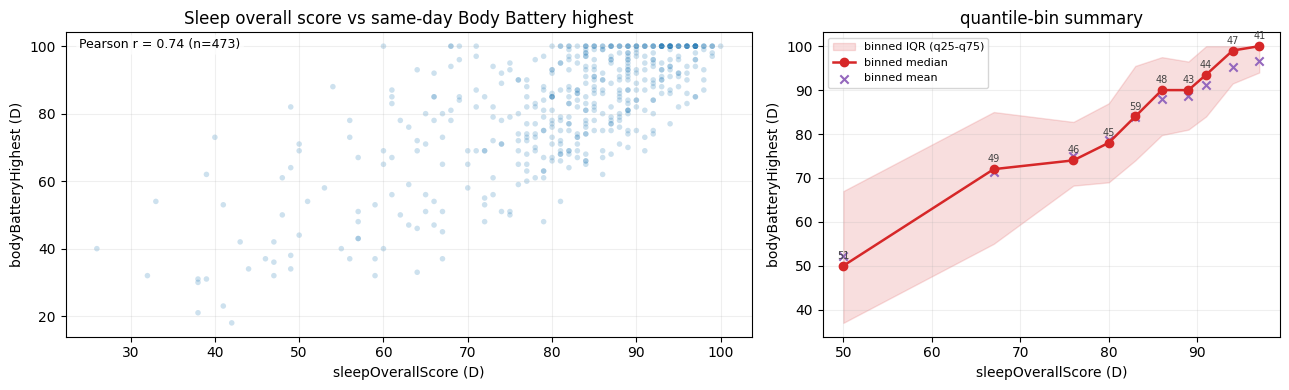

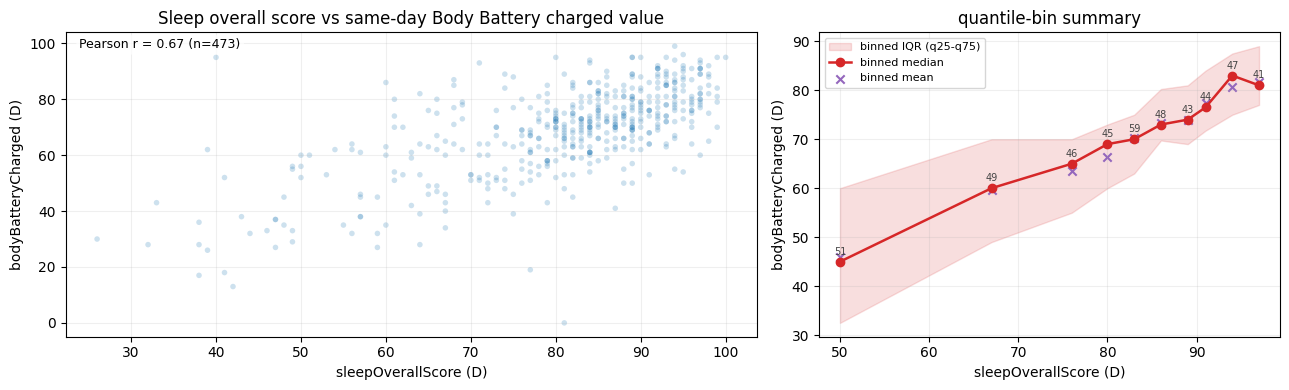

In [6]:
sleep_to_day_specs = [
    ('sleep_total_hours', 'awakeAverageStressLevel', 'Sleep duration vs same-day awake stress', 'sleep_total_hours (D)', 'awake stress (D)', 'rel_sleep_hours_to_awake_stress_same_day'),
    ('sleep_total_hours', 'active_hours', 'Sleep duration vs same-day active hours', 'sleep_total_hours (D)', 'active_hours (D)', 'rel_sleep_hours_to_active_hours_same_day'),
    ('sleepOverallScore', 'bodyBatteryHighest', 'Sleep overall score vs same-day Body Battery highest', 'sleepOverallScore (D)', 'bodyBatteryHighest (D)', 'rel_sleep_score_to_bb_highest_same_day'),
    ('sleepOverallScore', 'bodyBatteryCharged', 'Sleep overall score vs same-day Body Battery charged value', 'sleepOverallScore (D)', 'bodyBatteryCharged (D)', 'rel_sleep_score_to_bb_charged_same_day'),
]
for xcol, ycol, title, xlabel, ylabel, fig_name in sleep_to_day_specs:
    plot_relationship(df_sleep_e, xcol, ycol, title=title, xlabel=xlabel, ylabel=ylabel, fig_name=fig_name)


### 1.3 Daytime stress/activity -> next-night sleep (`D -> D+1 sleep`)

This is the centerpiece of the notebook: **does the way the day unfolded propagate into the following night?**

The focus is on stress burden, activity load, and daytime stress composition rather than generic same-row association hunting.


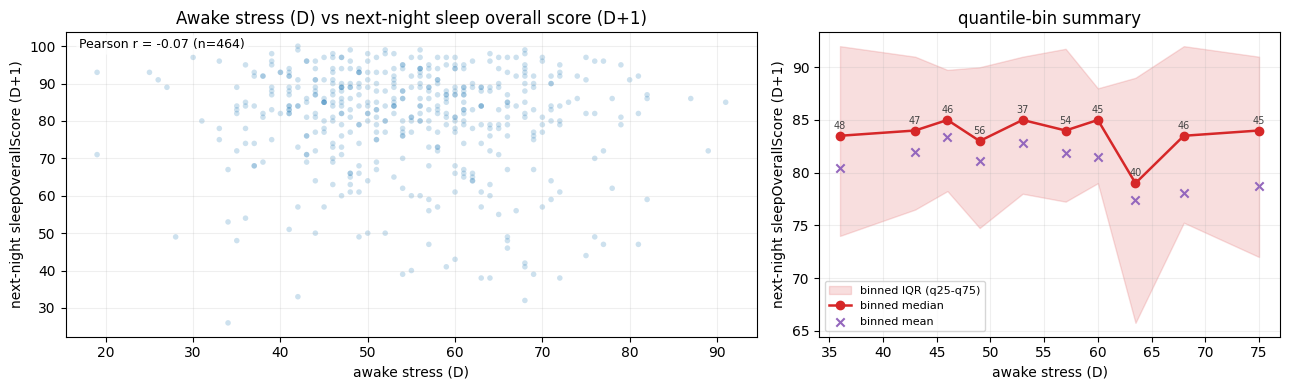

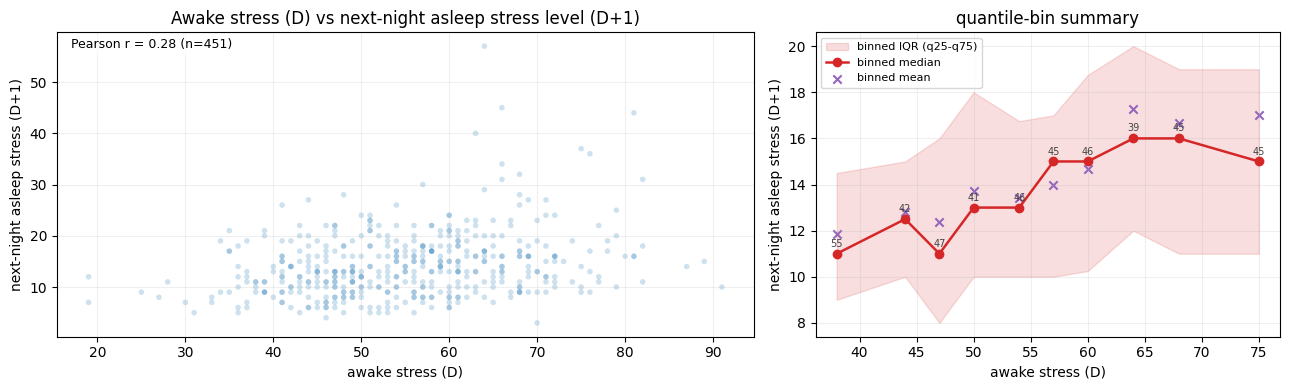

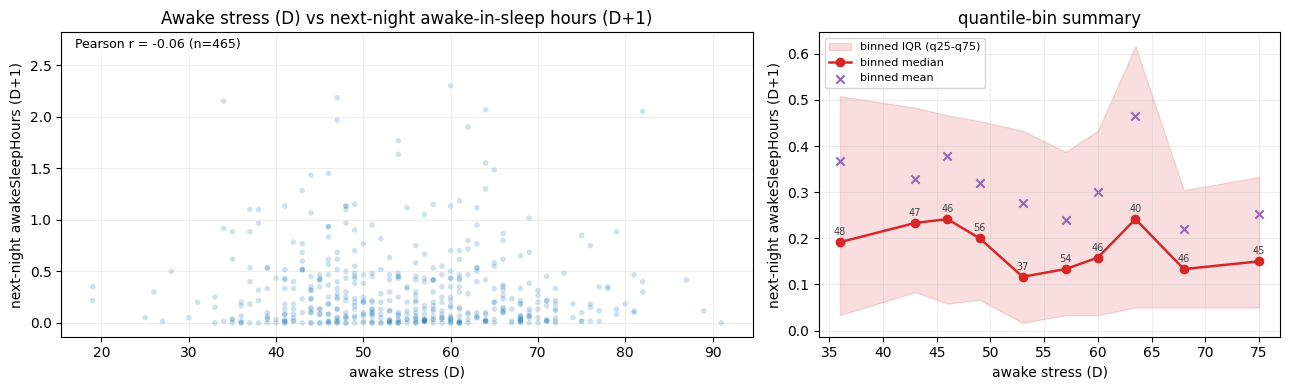

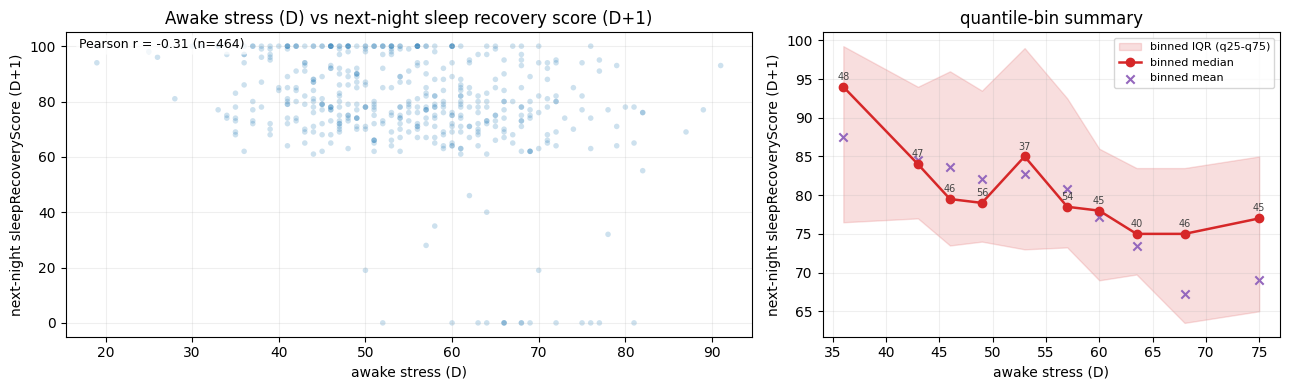

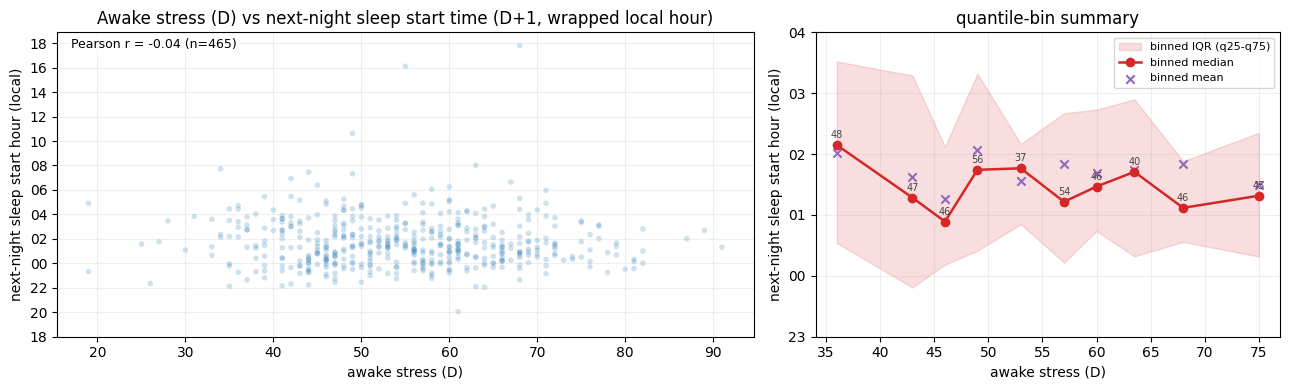

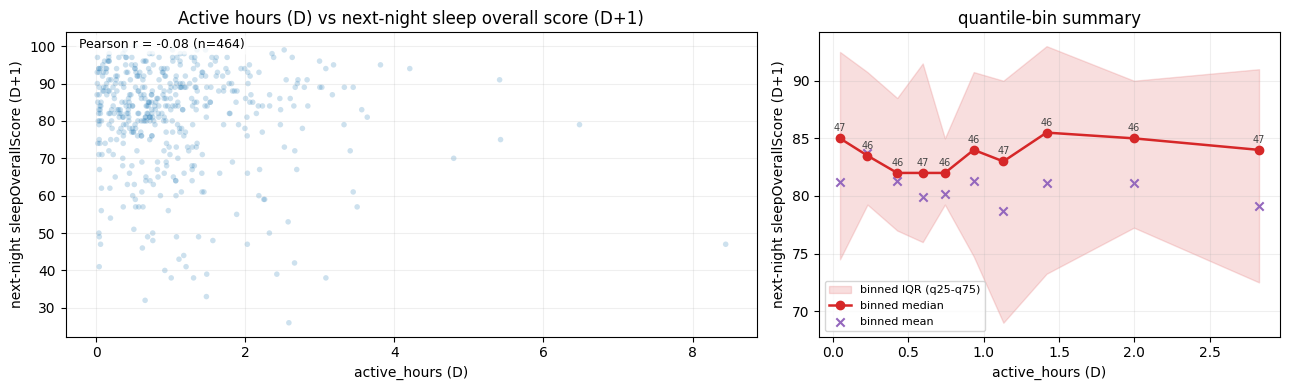

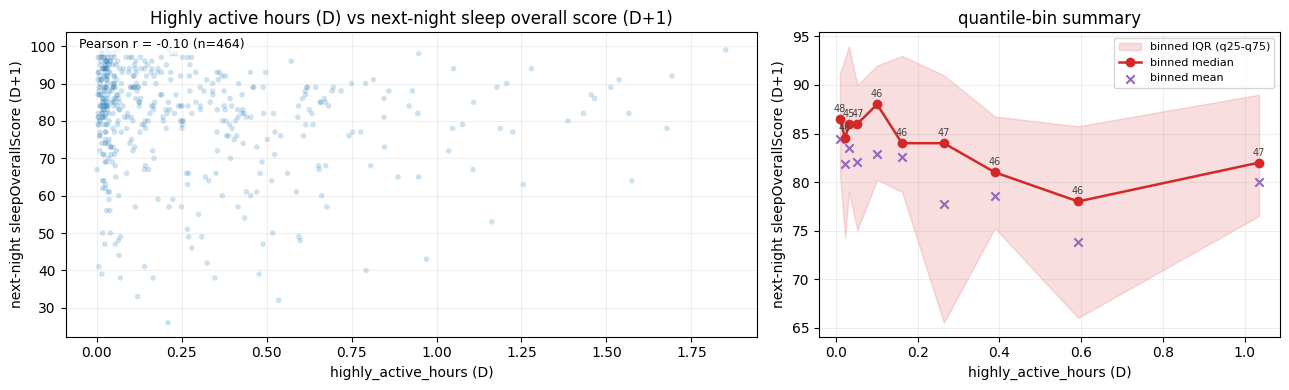

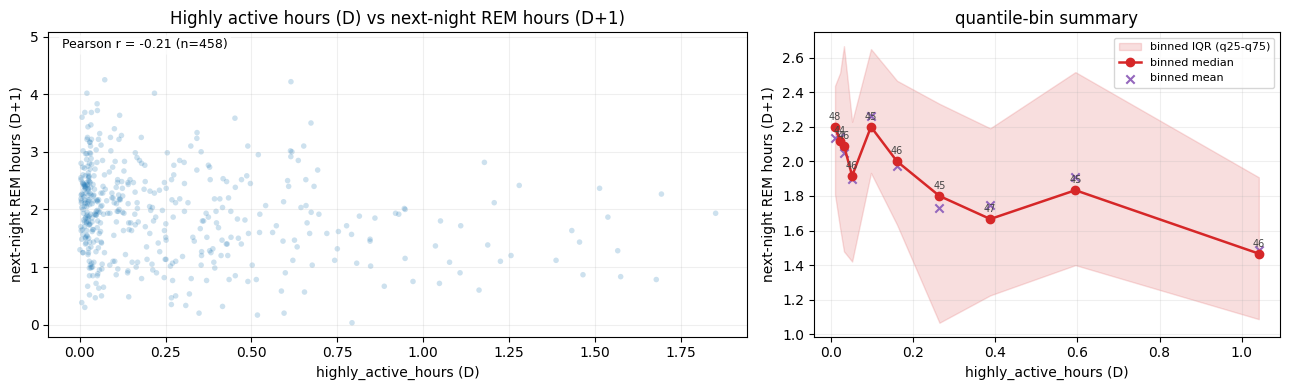

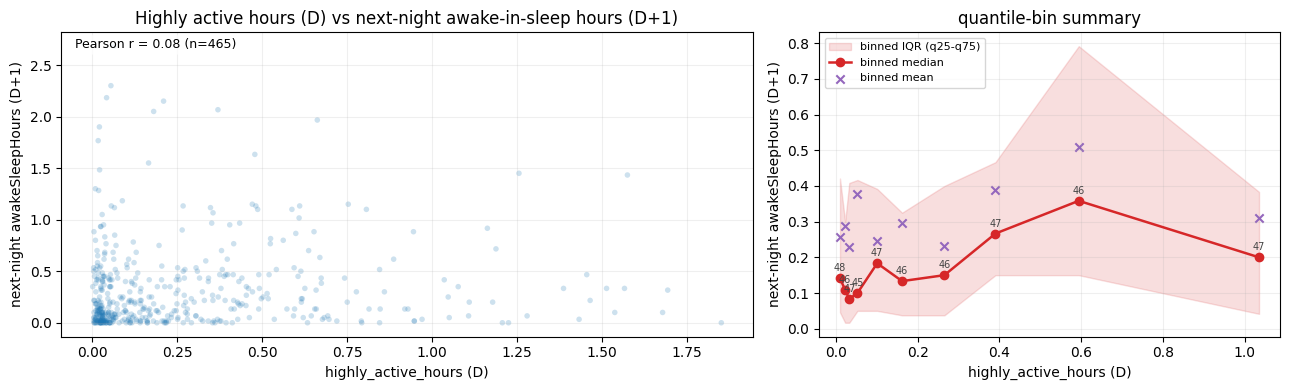

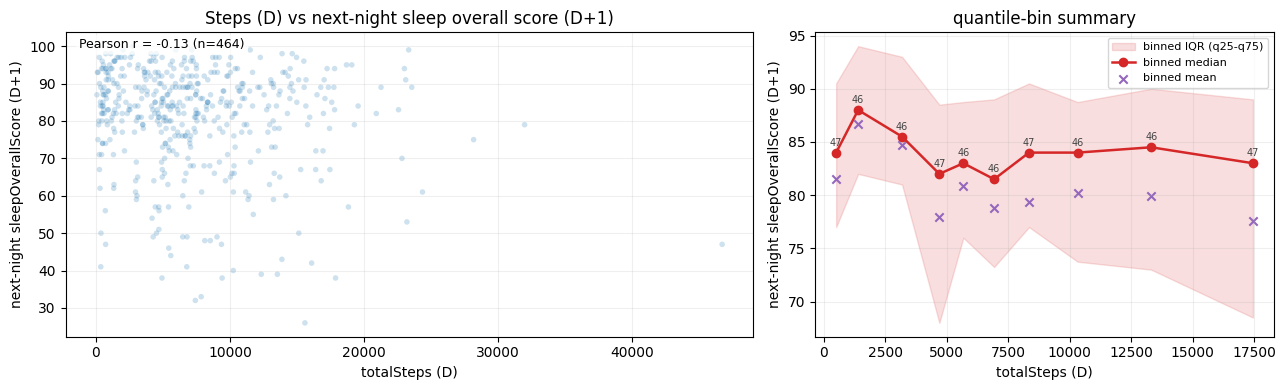

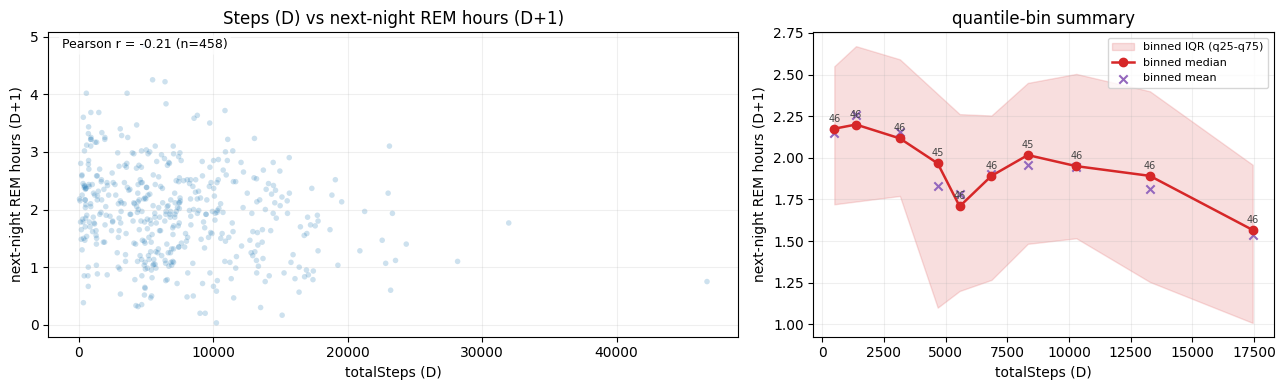

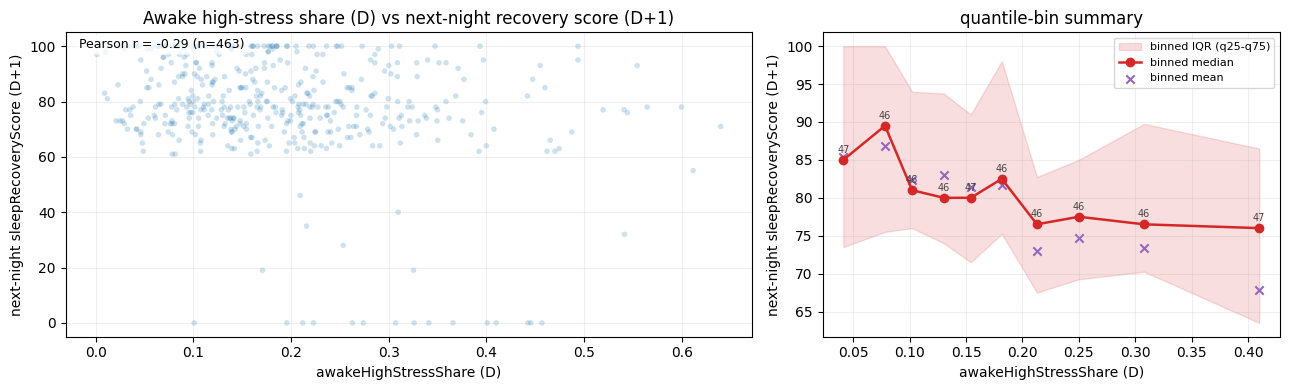

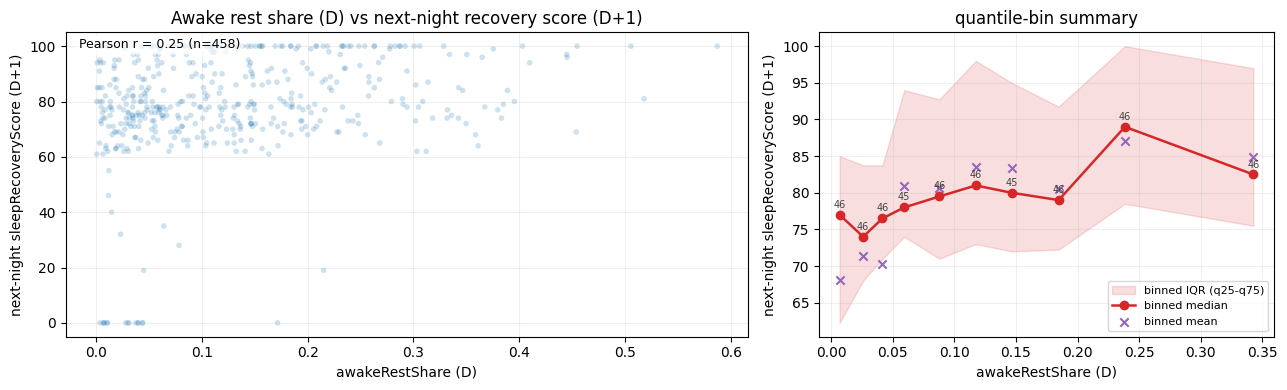

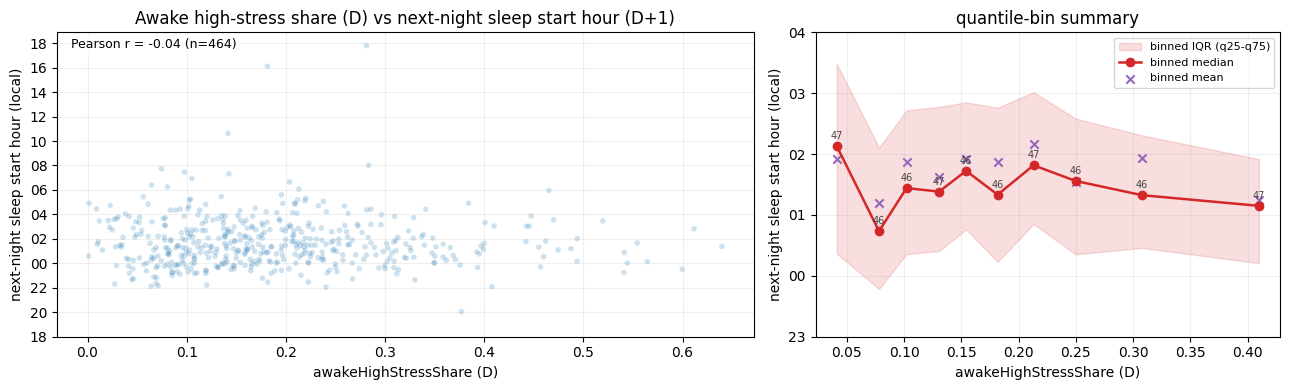

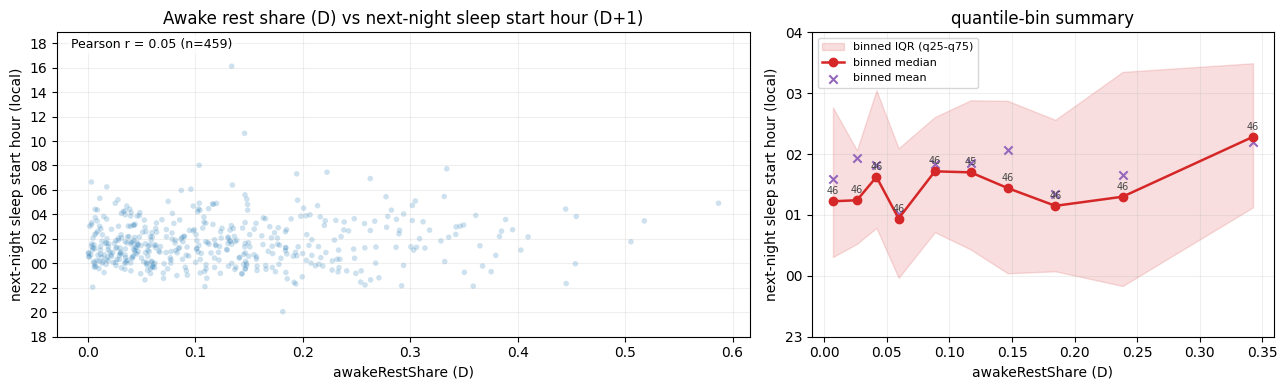

In [7]:
day_to_nextsleep_specs = [
    ('awakeAverageStressLevel', 'nextsleep_sleepOverallScore', 'Awake stress (D) vs next-night sleep overall score (D+1)', 'awake stress (D)', 'next-night sleepOverallScore (D+1)', 'rel_awake_stress_to_nextsleep_score', False, False),
    ('awakeAverageStressLevel', 'nextsleep_sleepAverageStressLevel', 'Awake stress (D) vs next-night asleep stress level (D+1)', 'awake stress (D)', 'next-night asleep stress (D+1)', 'rel_awake_stress_to_nextsleep_asleep_stress', False, False),
    ('awakeAverageStressLevel', 'nextsleep_awakeSleepHours', 'Awake stress (D) vs next-night awake-in-sleep hours (D+1)', 'awake stress (D)', 'next-night awakeSleepHours (D+1)', 'rel_awake_stress_to_nextsleep_awake_hours', False, False),
    ('awakeAverageStressLevel', 'nextsleep_sleepRecoveryScore', 'Awake stress (D) vs next-night sleep recovery score (D+1)', 'awake stress (D)', 'next-night sleepRecoveryScore (D+1)', 'rel_awake_stress_to_nextsleep_recovery', False, False),
    ('awakeAverageStressLevel', 'nextsleep_sleep_start_hour_local_wrapped', 'Awake stress (D) vs next-night sleep start time (D+1, wrapped local hour)', 'awake stress (D)', 'next-night sleep start hour (local)', 'rel_awake_stress_to_nextsleep_start_hour_wrapped', False, True),
    ('active_hours', 'nextsleep_sleepOverallScore', 'Active hours (D) vs next-night sleep overall score (D+1)', 'active_hours (D)', 'next-night sleepOverallScore (D+1)', 'rel_active_hours_to_nextsleep_score', False, False),
    ('highly_active_hours', 'nextsleep_sleepOverallScore', 'Highly active hours (D) vs next-night sleep overall score (D+1)', 'highly_active_hours (D)', 'next-night sleepOverallScore (D+1)', 'rel_highly_active_hours_to_nextsleep_score', False, False),
    ('highly_active_hours', 'nextsleep_remSleepHours', 'Highly active hours (D) vs next-night REM hours (D+1)', 'highly_active_hours (D)', 'next-night REM hours (D+1)', 'rel_highly_active_hours_to_nextsleep_rem', False, False),
    ('highly_active_hours', 'nextsleep_awakeSleepHours', 'Highly active hours (D) vs next-night awake-in-sleep hours (D+1)', 'highly_active_hours (D)', 'next-night awakeSleepHours (D+1)', 'rel_highly_active_hours_to_nextsleep_awake_hours', False, False),
    ('totalSteps', 'nextsleep_sleepOverallScore', 'Steps (D) vs next-night sleep overall score (D+1)', 'totalSteps (D)', 'next-night sleepOverallScore (D+1)', 'rel_steps_to_nextsleep_score', False, False),
    ('totalSteps', 'nextsleep_remSleepHours', 'Steps (D) vs next-night REM hours (D+1)', 'totalSteps (D)', 'next-night REM hours (D+1)', 'rel_steps_to_nextsleep_rem', False, False),
    ('awakeHighStressShare', 'nextsleep_sleepRecoveryScore', 'Awake high-stress share (D) vs next-night recovery score (D+1)', 'awakeHighStressShare (D)', 'next-night sleepRecoveryScore (D+1)', 'rel_awake_high_stress_share_to_nextsleep_recovery', False, False),
    ('awakeRestShare', 'nextsleep_sleepRecoveryScore', 'Awake rest share (D) vs next-night recovery score (D+1)', 'awakeRestShare (D)', 'next-night sleepRecoveryScore (D+1)', 'rel_awake_rest_share_to_nextsleep_recovery', False, False),
    ('awakeHighStressShare', 'nextsleep_sleep_start_hour_local_wrapped', 'Awake high-stress share (D) vs next-night sleep start hour (D+1)', 'awakeHighStressShare (D)', 'next-night sleep start hour (local)', 'rel_awake_high_stress_share_to_nextsleep_start_hour_wrapped', False, True),
    ('awakeRestShare', 'nextsleep_sleep_start_hour_local_wrapped', 'Awake rest share (D) vs next-night sleep start hour (D+1)', 'awakeRestShare (D)', 'next-night sleep start hour (local)', 'rel_awake_rest_share_to_nextsleep_start_hour_wrapped', False, True),
]

# Safety guard: drop sentinel/out-of-range stress levels even if upstream cell was not rerun.
df_day_nextsleep_plot = df_day_nextsleep.copy()
for col in ['awakeAverageStressLevel', 'nextsleep_sleepAverageStressLevel']:
    if col in df_day_nextsleep_plot.columns:
        s = pd.to_numeric(df_day_nextsleep_plot[col], errors='coerce')
        bad_mask = ~(s.between(0, 100) | s.isna())
        if bad_mask.any():
            print(f'Filtered {int(bad_mask.sum())} out-of-range values in {col} for 1.3 plots')
        df_day_nextsleep_plot[col] = s.where(s.between(0, 100))

for xcol, ycol, title, xlabel, ylabel, fig_name, clock_axis_x, clock_axis_y in day_to_nextsleep_specs:
    plot_relationship(
        df_day_nextsleep_plot,
        xcol,
        ycol,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        fig_name=fig_name,
        clock_axis_x=clock_axis_x,
        clock_axis_y=clock_axis_y,
    )


### 1.4 Sleep-internal relationships (same-row, structural)

These plots explain how the sleep subsystem itself behaves: duration, timing, stress, stages, and score composition.

One plot in this section is intentionally diagnostic rather than explanatory: `avgSleepStress` vs `sleepAverageStressLevel`. It reconciles two related but distinct sources:
- `avgSleepStress`: sleep-side summary metric
- `sleepAverageStressLevel`: UDS `ASLEEP` stress sub-aggregator


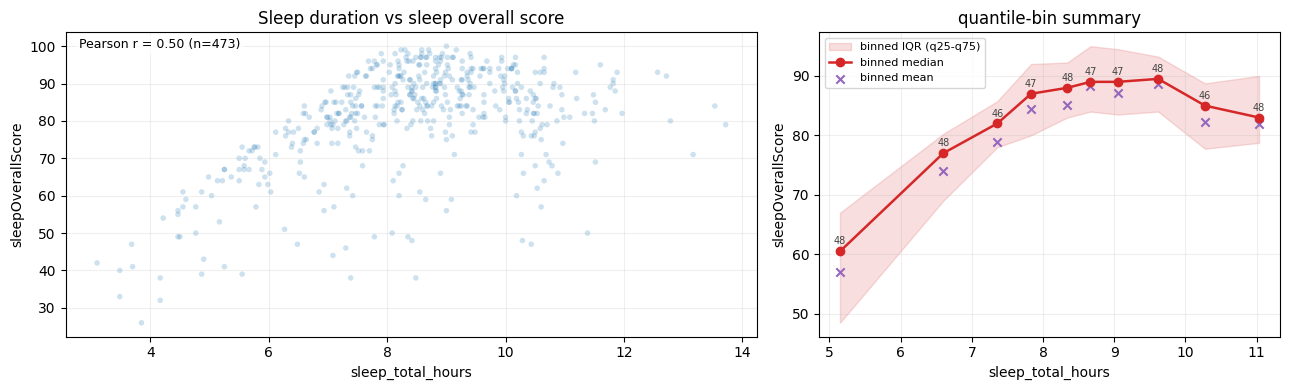

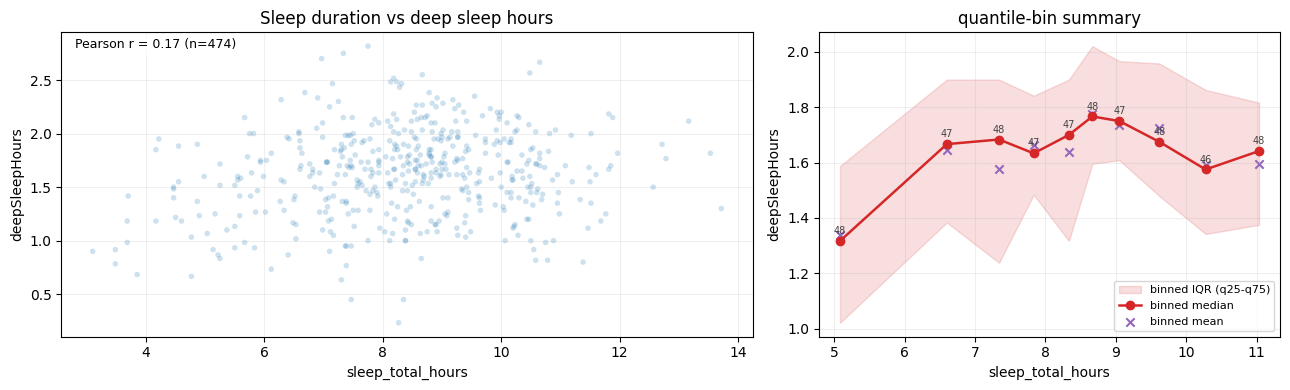

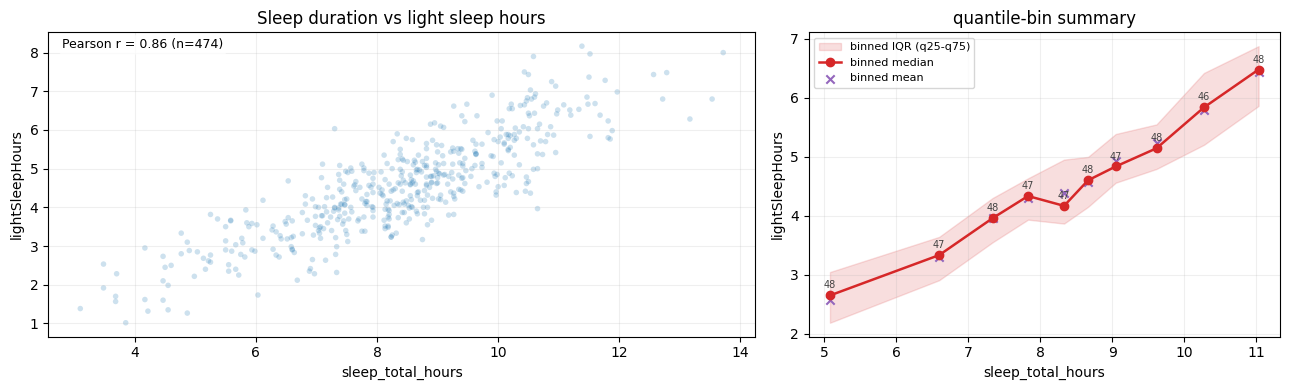

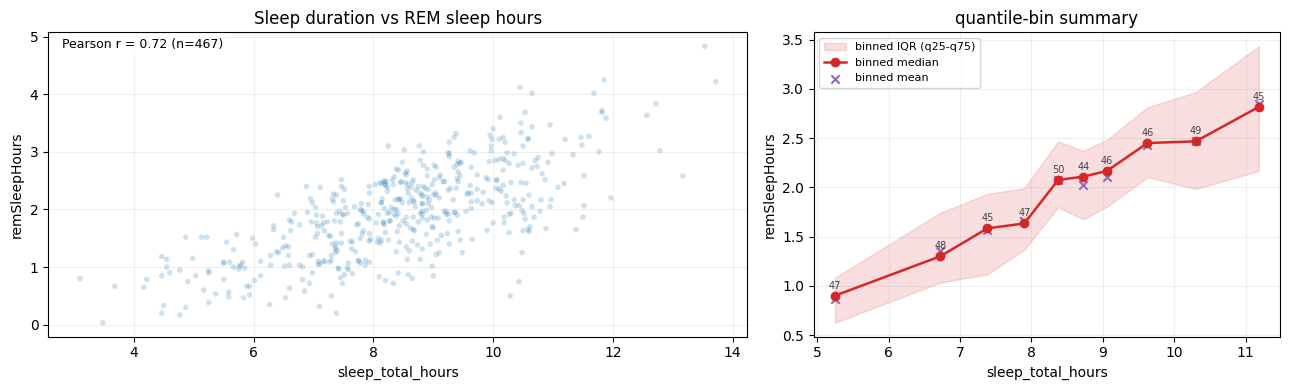

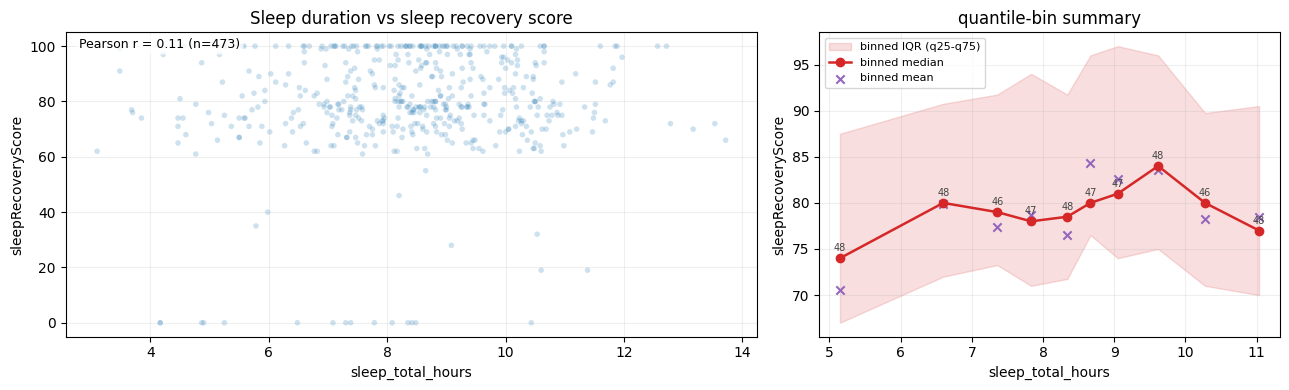

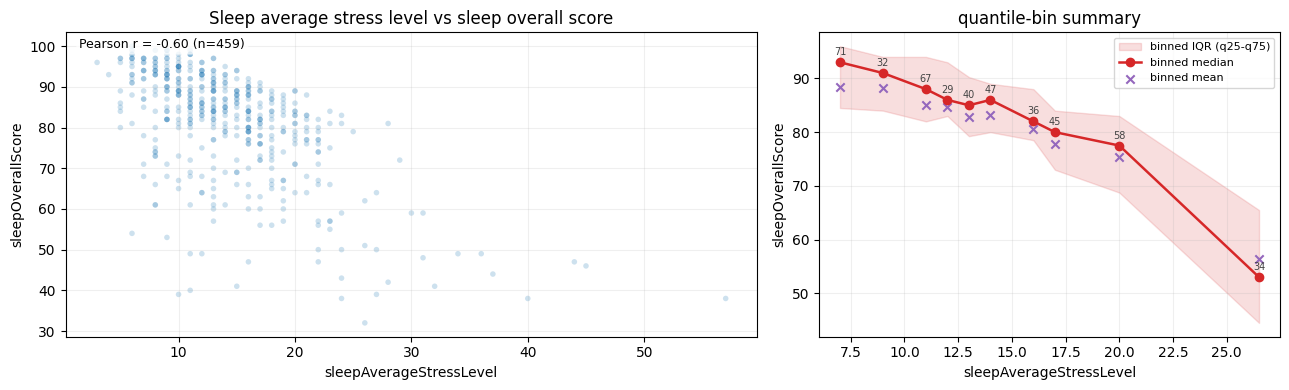

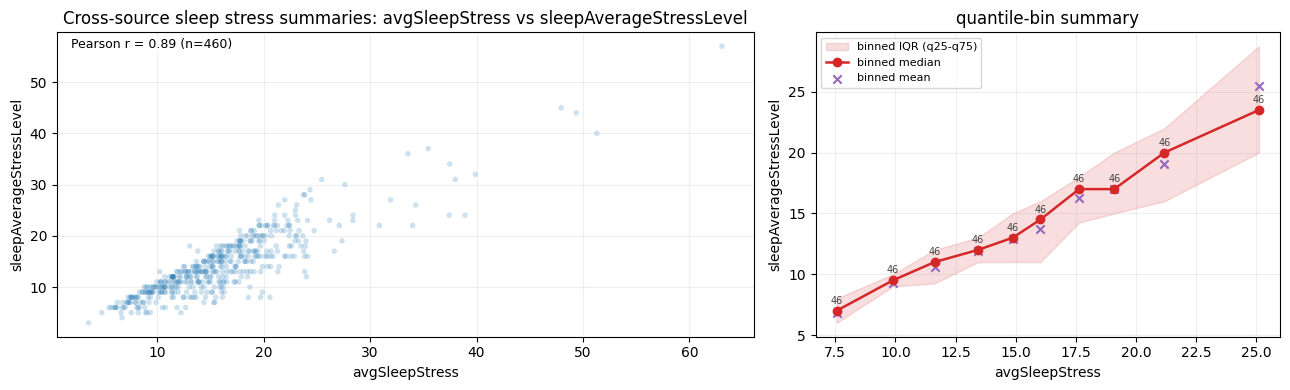

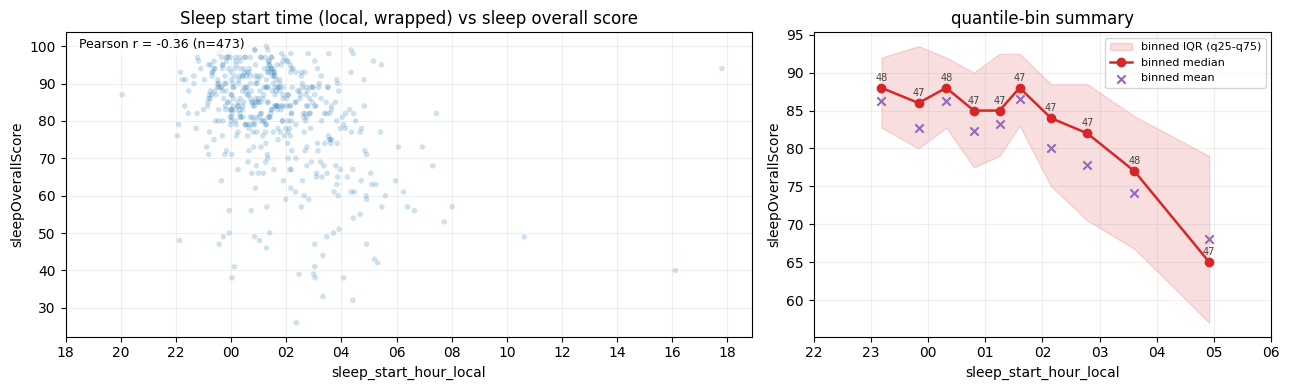

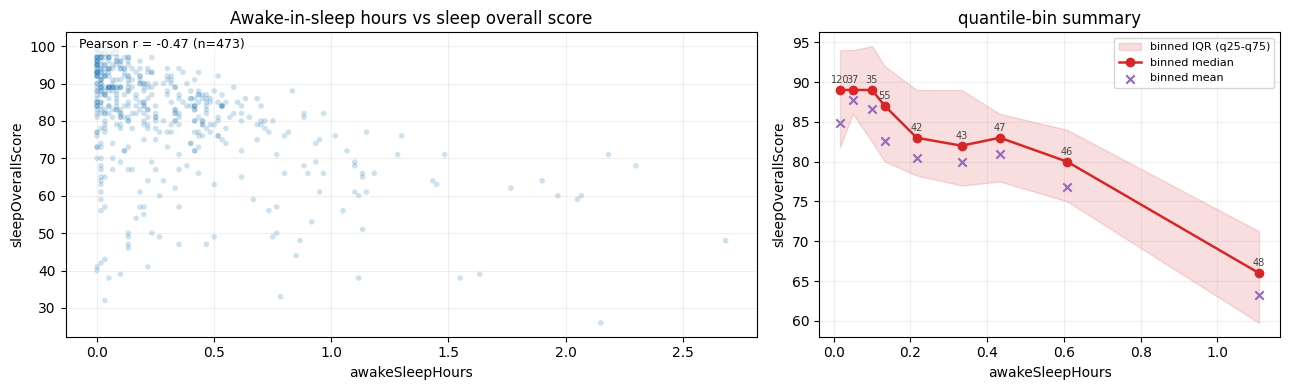

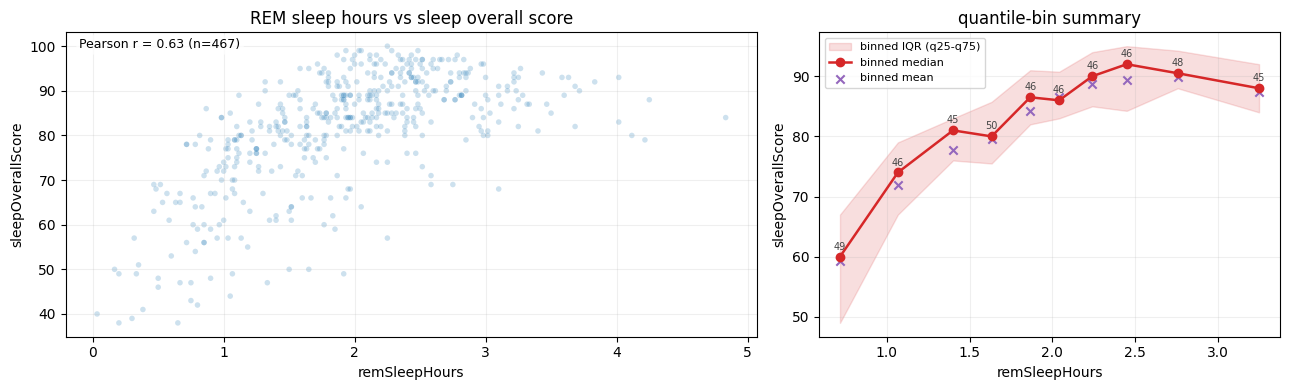

In [8]:
sleep_internal_specs = [
    ('sleep_total_hours', 'sleepOverallScore', 'Sleep duration vs sleep overall score', 'sleep_total_hours', 'sleepOverallScore', 'rel_sleep_hours_vs_sleep_score_same_row', False, False),
    ('sleep_total_hours', 'deepSleepHours', 'Sleep duration vs deep sleep hours', 'sleep_total_hours', 'deepSleepHours', 'rel_sleep_hours_vs_deep_sleep_hours', False, False),
    ('sleep_total_hours', 'lightSleepHours', 'Sleep duration vs light sleep hours', 'sleep_total_hours', 'lightSleepHours', 'rel_sleep_hours_vs_light_sleep_hours', False, False),
    ('sleep_total_hours', 'remSleepHours', 'Sleep duration vs REM sleep hours', 'sleep_total_hours', 'remSleepHours', 'rel_sleep_hours_vs_rem_sleep_hours', False, False),
    ('sleep_total_hours', 'sleepRecoveryScore', 'Sleep duration vs sleep recovery score', 'sleep_total_hours', 'sleepRecoveryScore', 'rel_sleep_hours_vs_sleep_recovery_score', False, False),
    ('sleepAverageStressLevel', 'sleepOverallScore', 'Sleep average stress level vs sleep overall score', 'sleepAverageStressLevel', 'sleepOverallScore', 'rel_sleep_avg_stress_level_vs_sleep_score', False, False),
    ('avgSleepStress', 'sleepAverageStressLevel', 'Cross-source sleep stress summaries: avgSleepStress vs sleepAverageStressLevel', 'avgSleepStress', 'sleepAverageStressLevel', 'rel_avg_sleep_stress_vs_sleep_average_stress_level', False, False),
    ('sleep_start_hour_local_wrapped', 'sleepOverallScore', 'Sleep start time (local, wrapped) vs sleep overall score', 'sleep_start_hour_local', 'sleepOverallScore', 'rel_sleep_start_hour_local_wrapped_vs_sleep_score', True, False),
    ('awakeSleepHours', 'sleepOverallScore', 'Awake-in-sleep hours vs sleep overall score', 'awakeSleepHours', 'sleepOverallScore', 'rel_awake_sleep_hours_vs_sleep_score', False, False),
    ('remSleepHours', 'sleepOverallScore', 'REM sleep hours vs sleep overall score', 'remSleepHours', 'sleepOverallScore', 'rel_rem_sleep_hours_vs_sleep_score', False, False),
]
for xcol, ycol, title, xlabel, ylabel, fig_name, clock_axis_x, clock_axis_y in sleep_internal_specs:
    plot_relationship(
        df_sleep_e,
        xcol,
        ycol,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        fig_name=fig_name,
        clock_axis_x=clock_axis_x,
        clock_axis_y=clock_axis_y,
    )




### 1.5 Exploratory same-day daytime interactions (optional / hypothesis seeding)

This section is intentionally small. These are same-day daytime pairings that may suggest mechanisms or follow-up questions, but they are not the main causal narrative of the notebook.


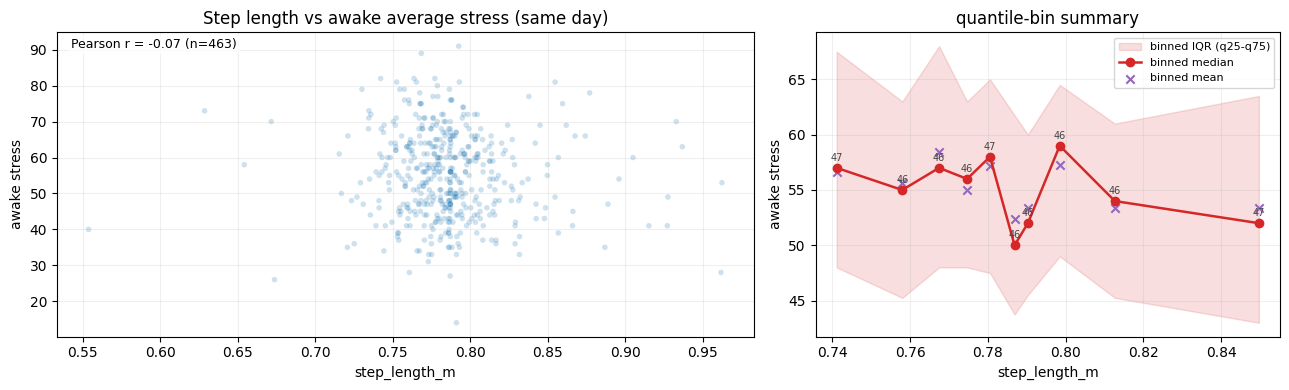

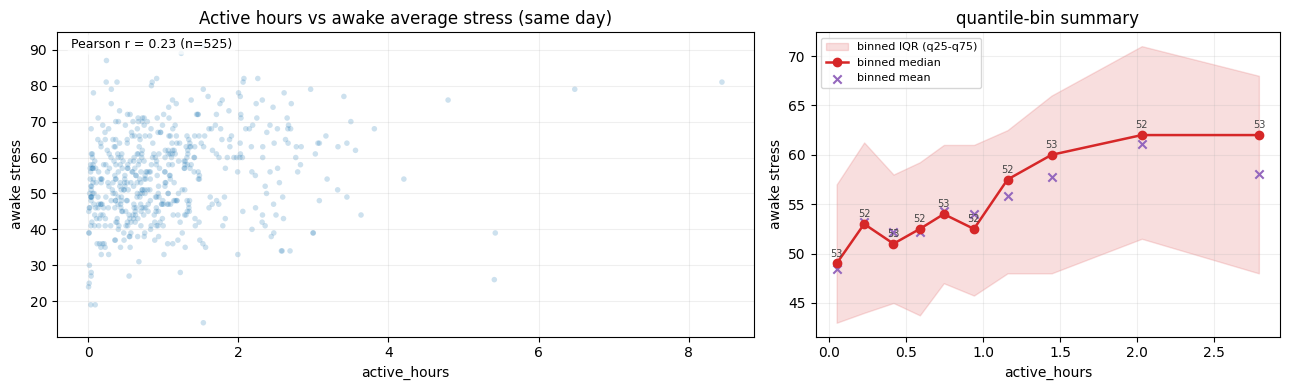

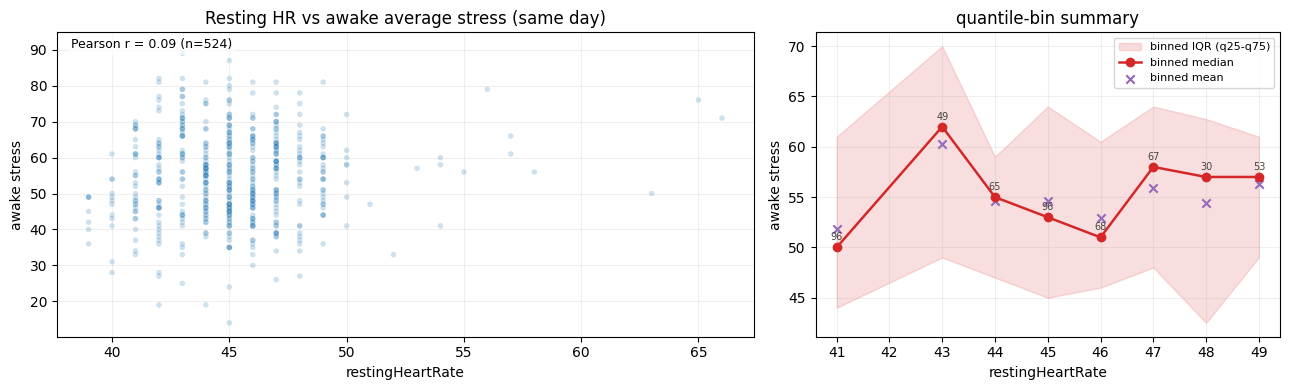

In [9]:
same_day_exploratory_specs = [
    ('step_length_m', 'awakeAverageStressLevel', 'Step length vs awake average stress (same day)', 'step_length_m', 'awake stress', 'rel_step_length_vs_awake_stress'),
    ('active_hours', 'awakeAverageStressLevel', 'Active hours vs awake average stress (same day)', 'active_hours', 'awake stress', 'rel_active_hours_vs_awake_stress_same_day'),
    ('restingHeartRate', 'awakeAverageStressLevel', 'Resting HR vs awake average stress (same day)', 'restingHeartRate', 'awake stress', 'rel_resting_hr_vs_awake_stress_same_day'),
]
for xcol, ycol, title, xlabel, ylabel, fig_name in same_day_exploratory_specs:
    plot_relationship(df_strict_e, xcol, ycol, title=title, xlabel=xlabel, ylabel=ylabel, fig_name=fig_name)


### 1.6 Correlation matrices (grouped `core` / `extended` submatrices)

Instead of one giant matrix, build **curated submatrices** with explicit temporal semantics and grouped feature sets:
- `asleep(D)` (night metrics at start of day `D`)
- `awake(D)` (daytime activity/stress after waking, same `calendarDate`)
- `physiology_energy(D)` (heart + Body Battery summaries, mixed timing within day)
- `stress_asleep(D)` (Garmin ASLEEP stress sub-aggregator)
- optional `total(D)` stress summaries (supporting)

Core matrices are compact and readable; extended matrices add more variables (stages, respiration/SpO2, stress duration/share components, floors/distance, etc.). Correlation is **screening/triage**, not causal proof.


                       group       frame  n_metrics  n_present
               asleep_core_D  df_sleep_e         11         11
           asleep_extended_D  df_sleep_e          6          6
                awake_core_D df_strict_e          8          8
            awake_extended_D df_strict_e         10         10
    physiology_energy_core_D df_strict_e          6          6
physiology_energy_extended_D df_strict_e          5          5
        stress_asleep_core_D  df_sleep_e          6          6
    stress_asleep_extended_D  df_sleep_e          7          7
     stress_total_extended_D df_strict_e          7          7


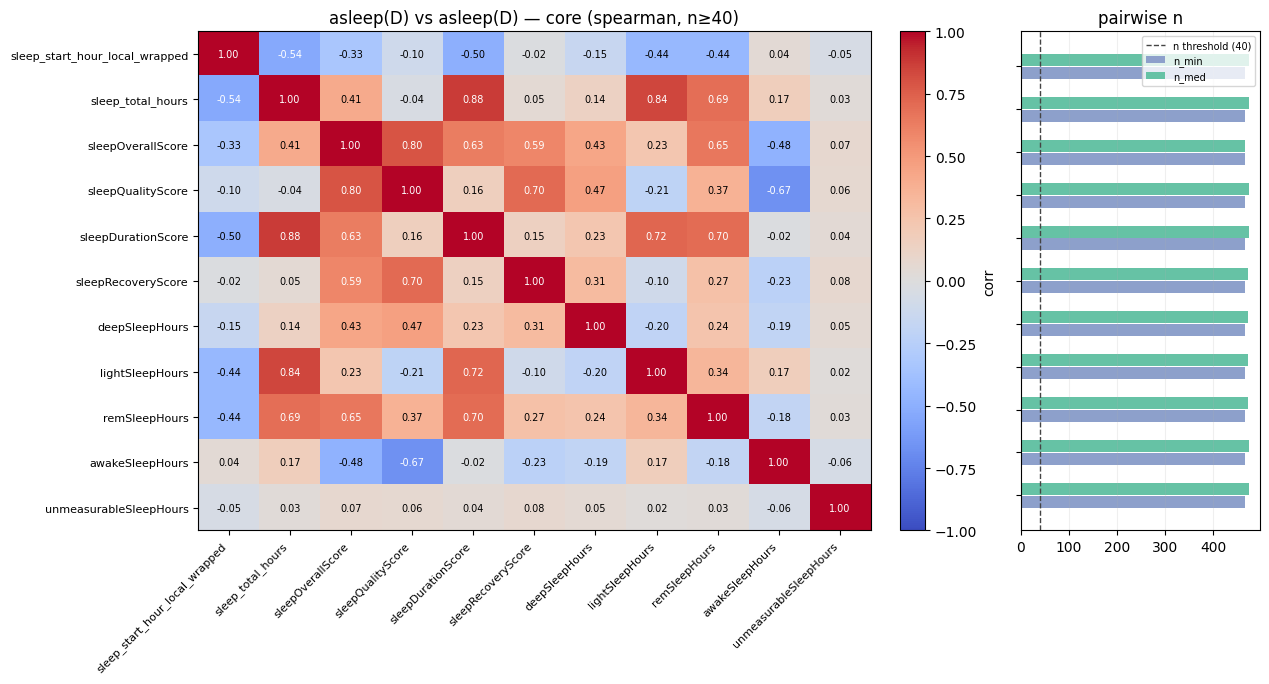

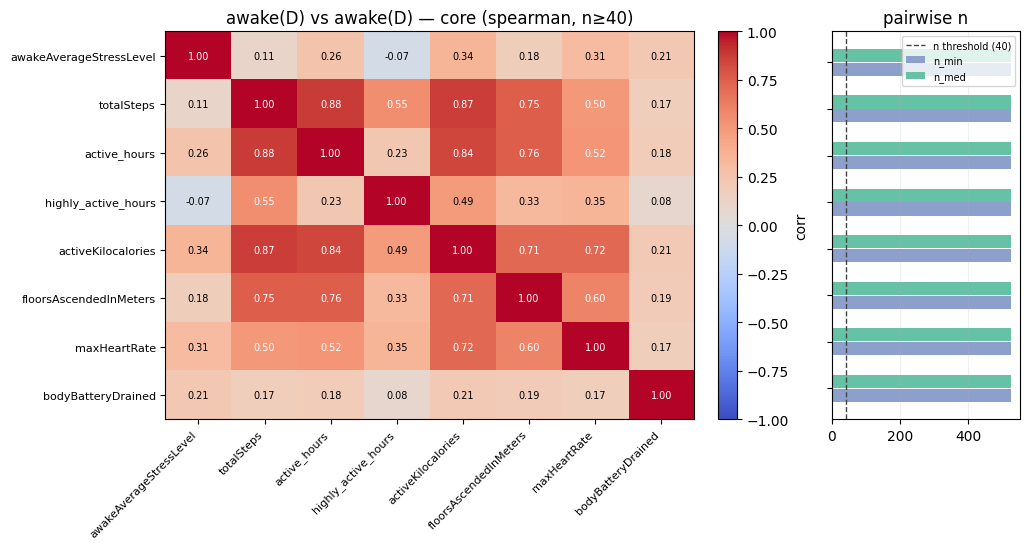

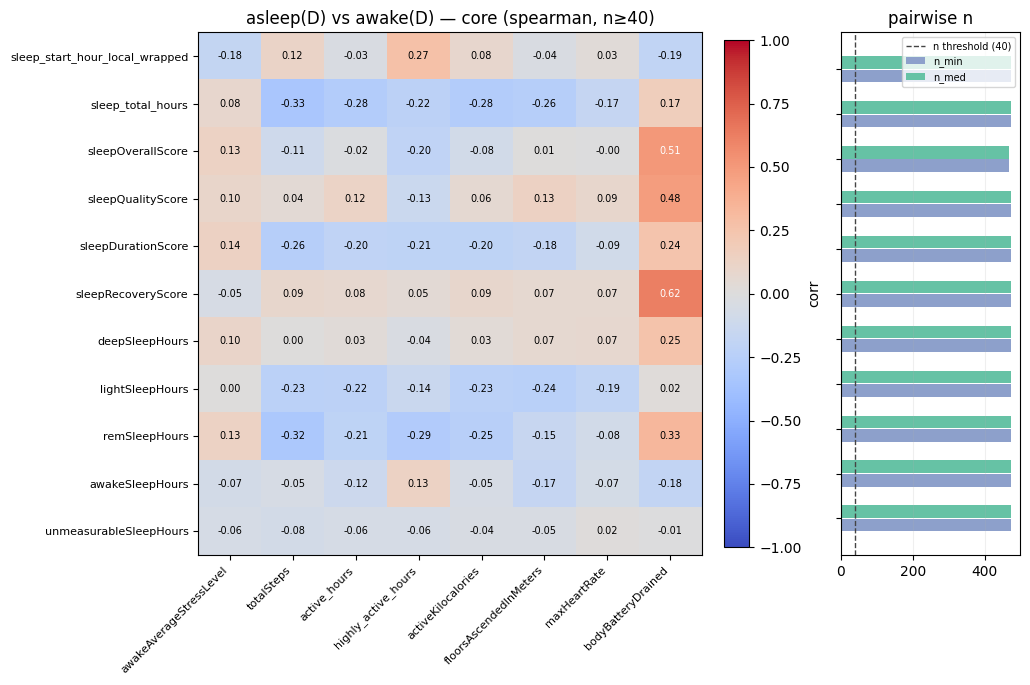

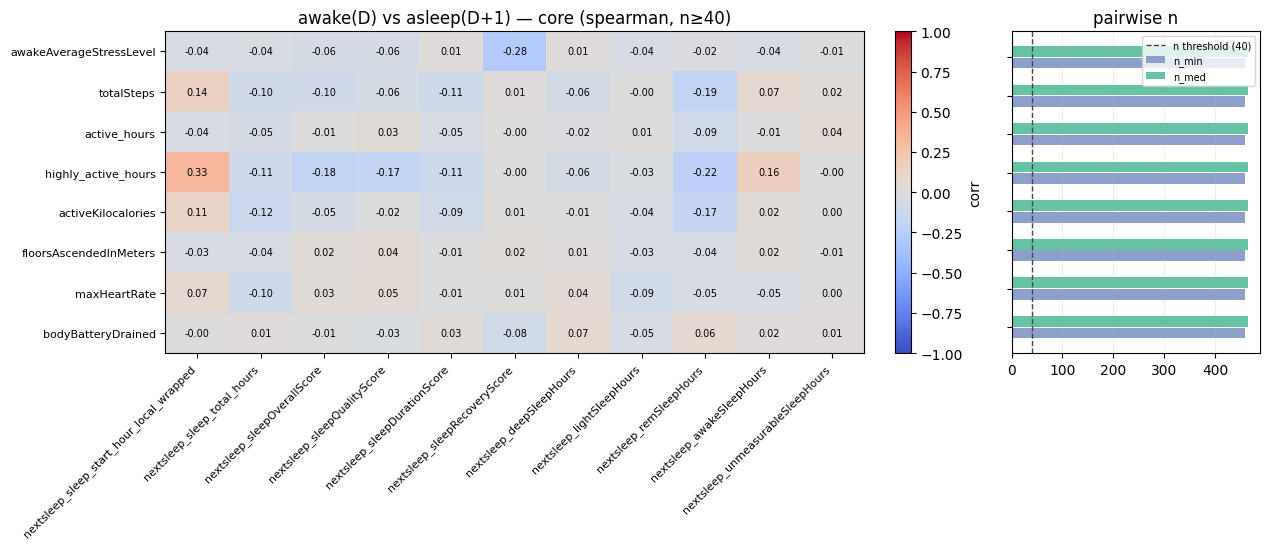

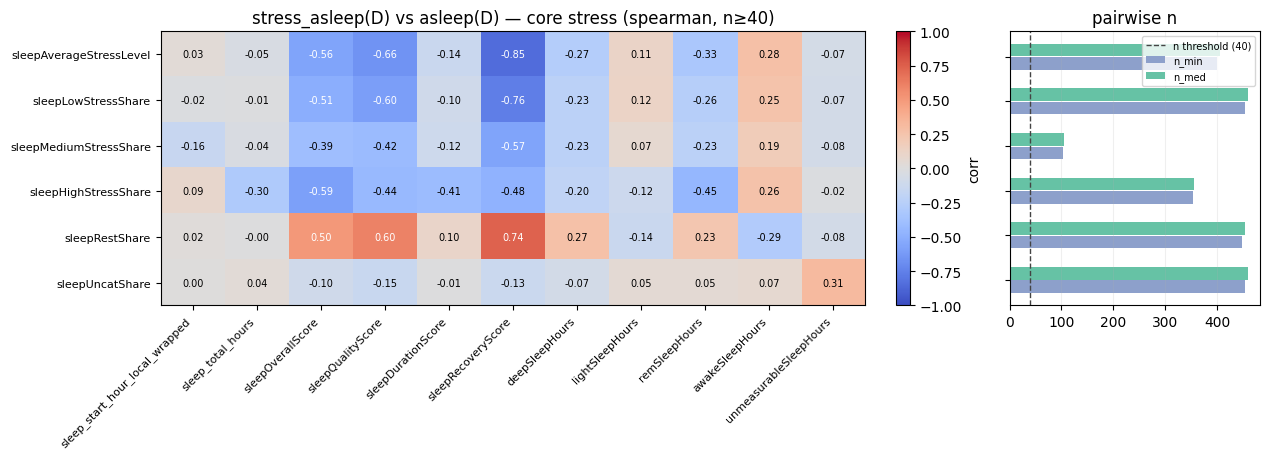

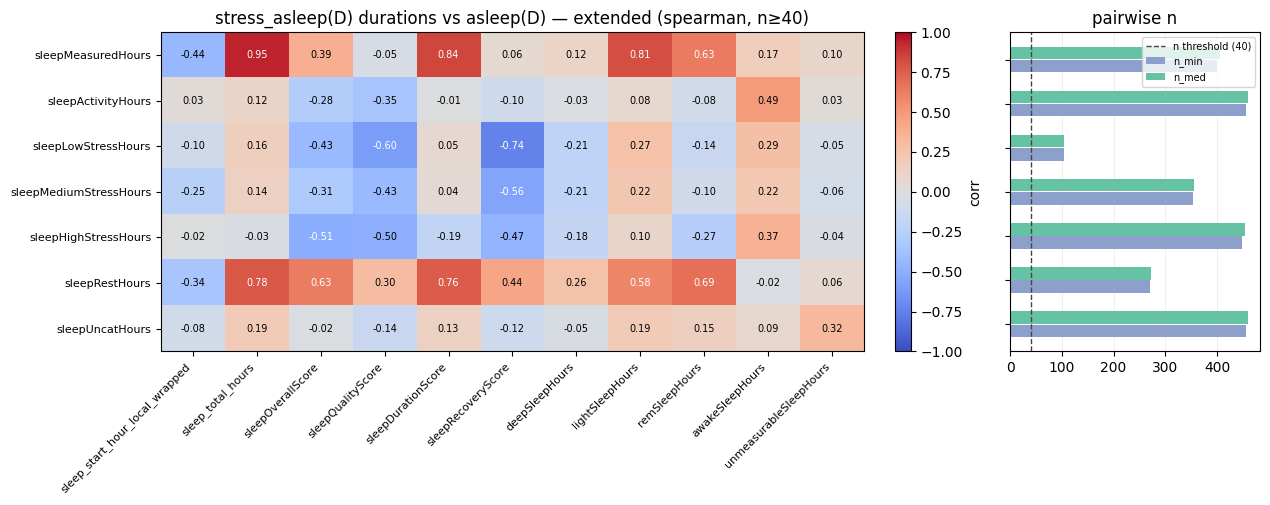

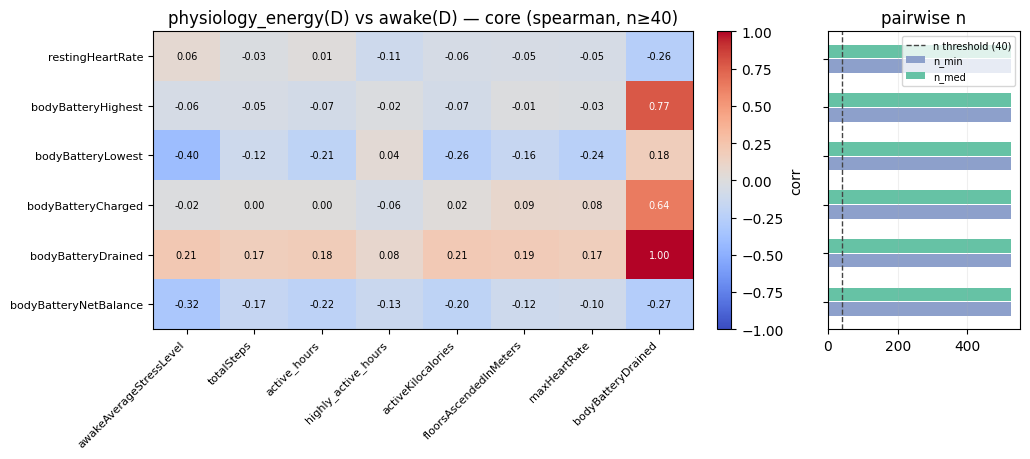

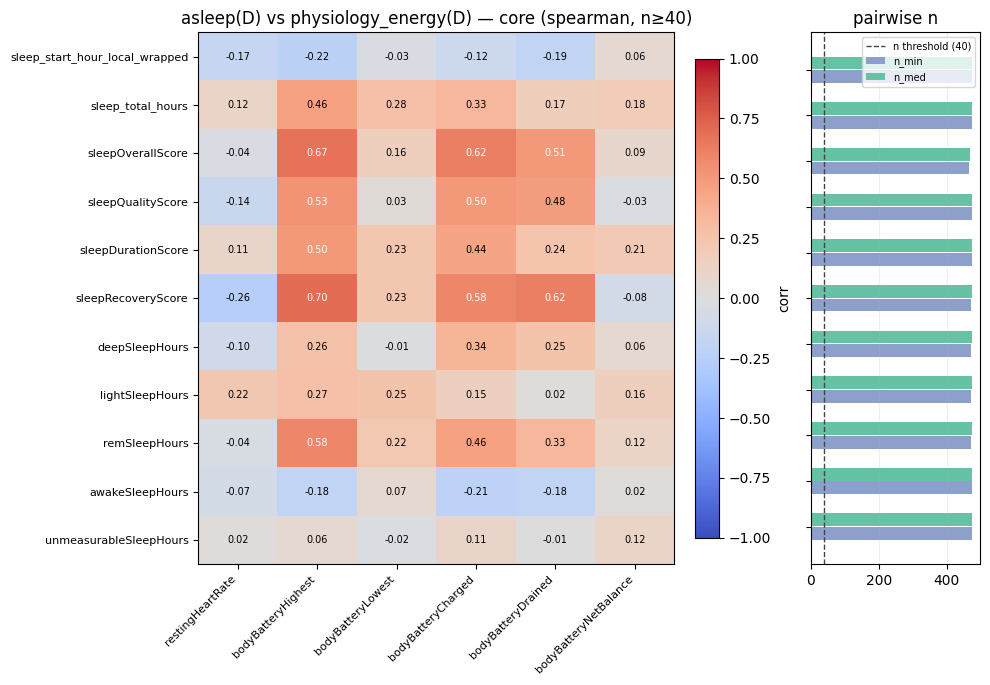

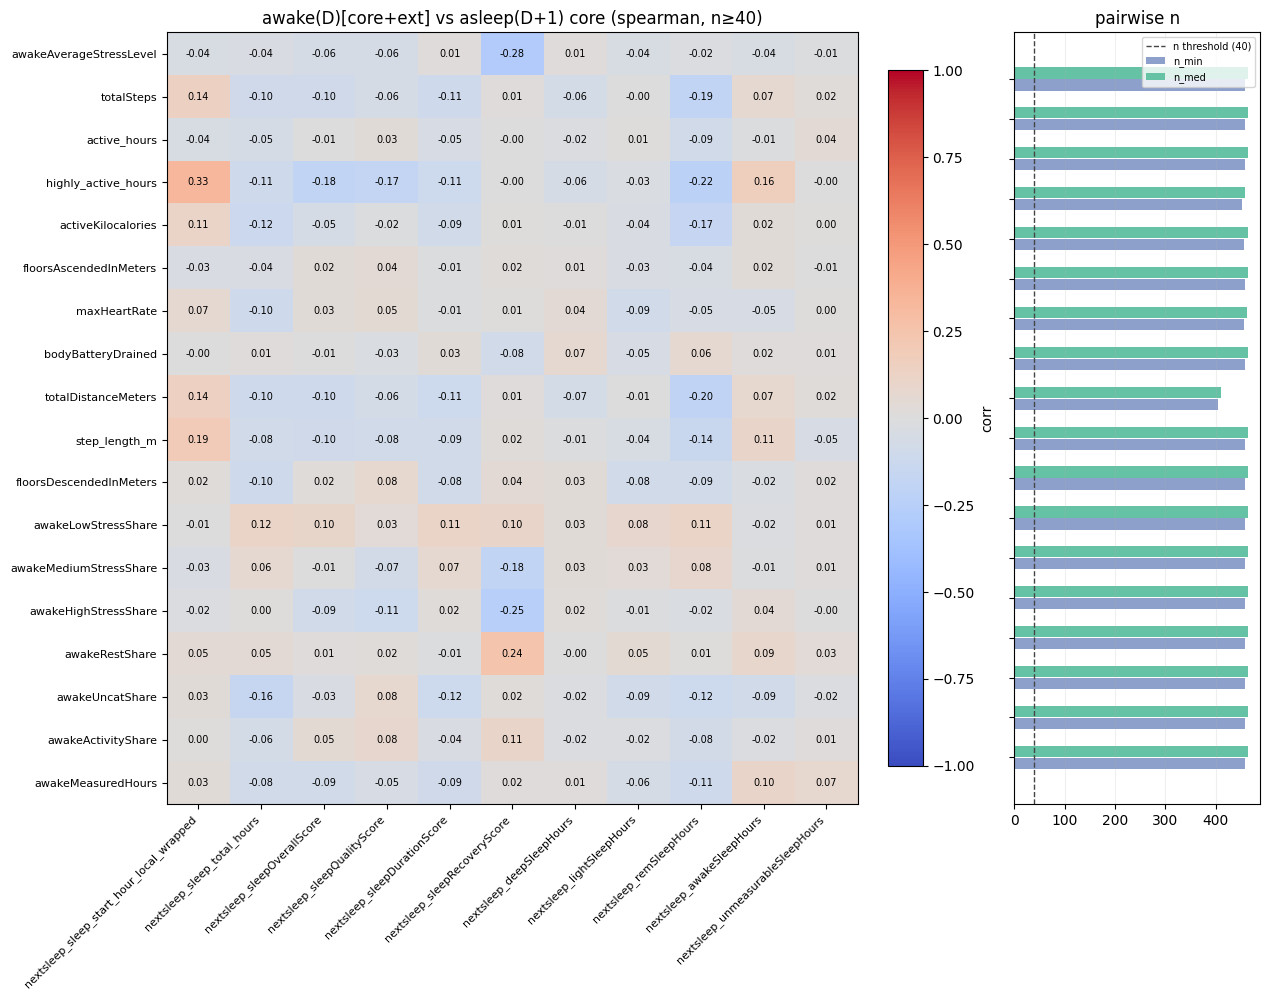

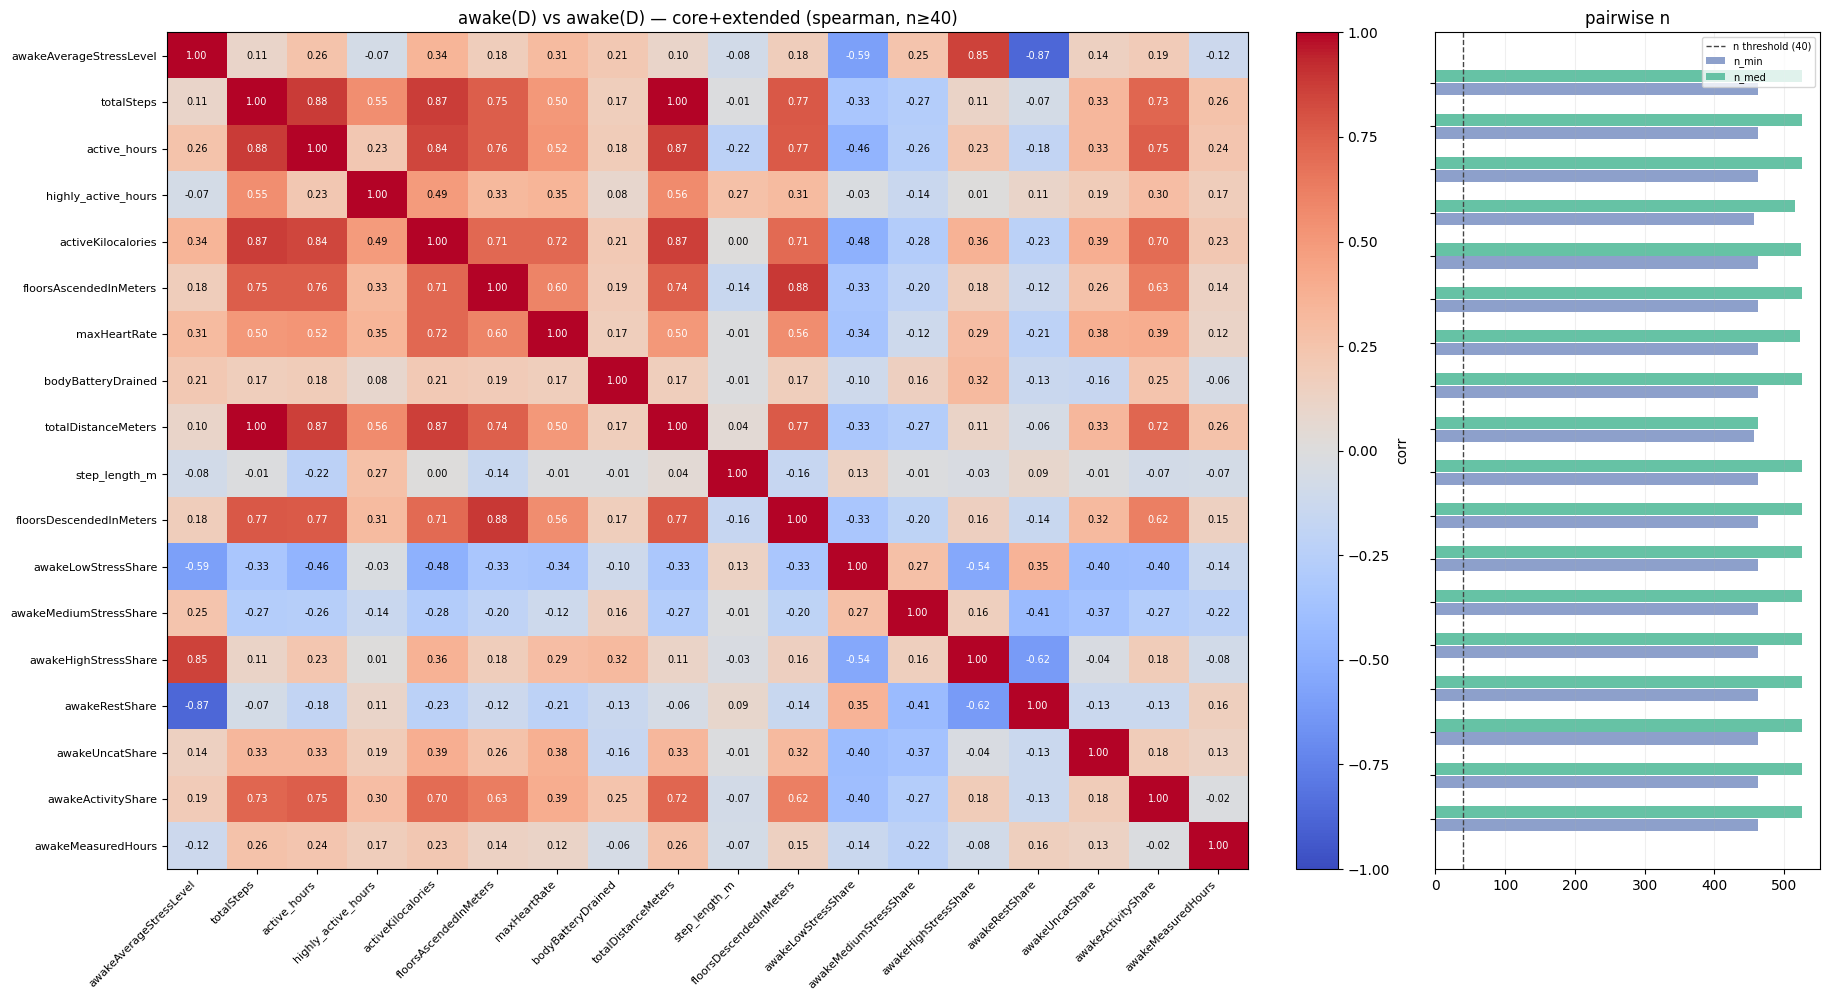

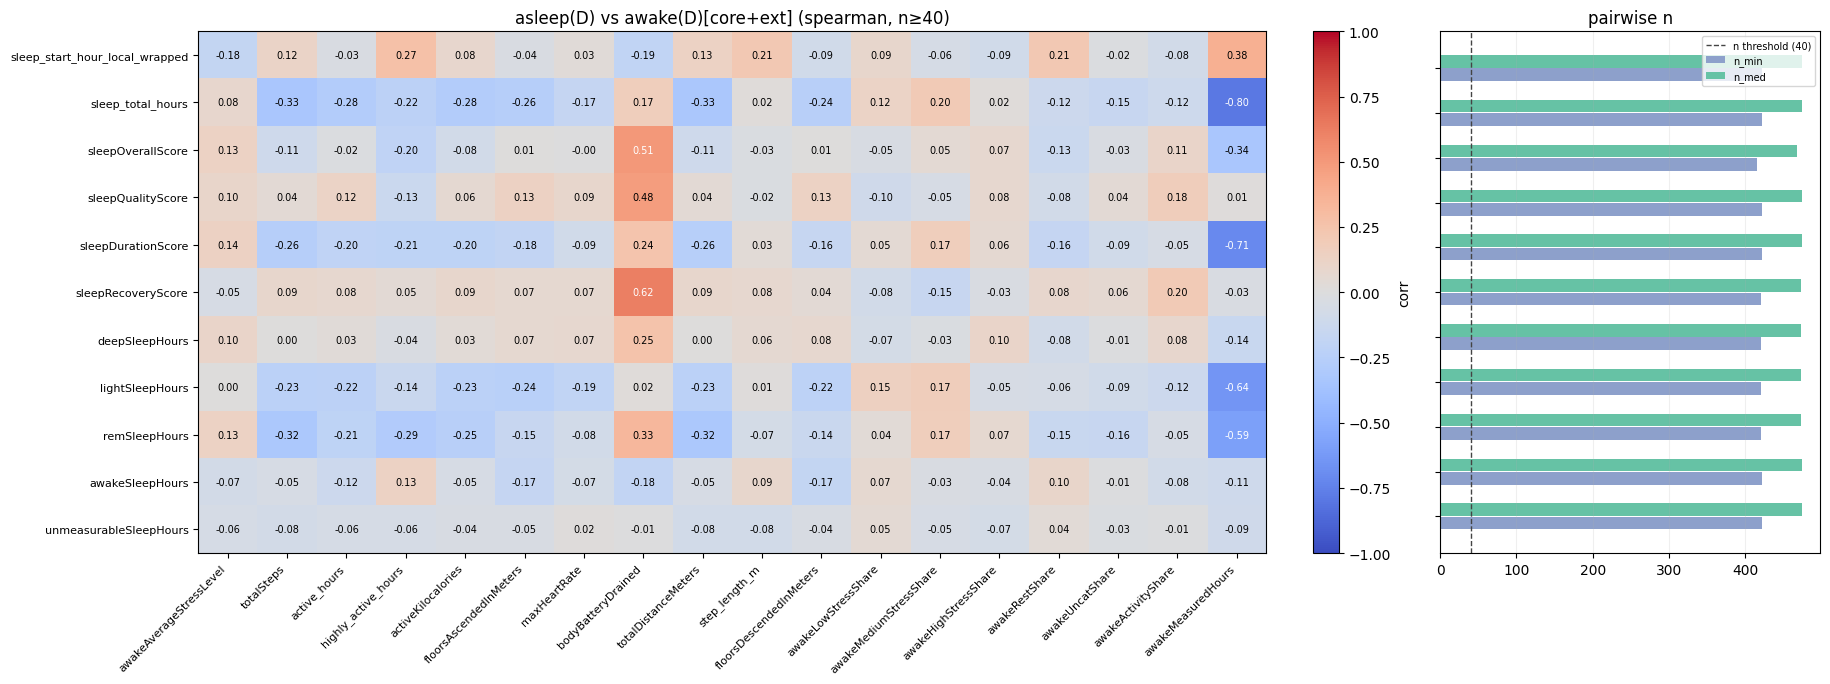

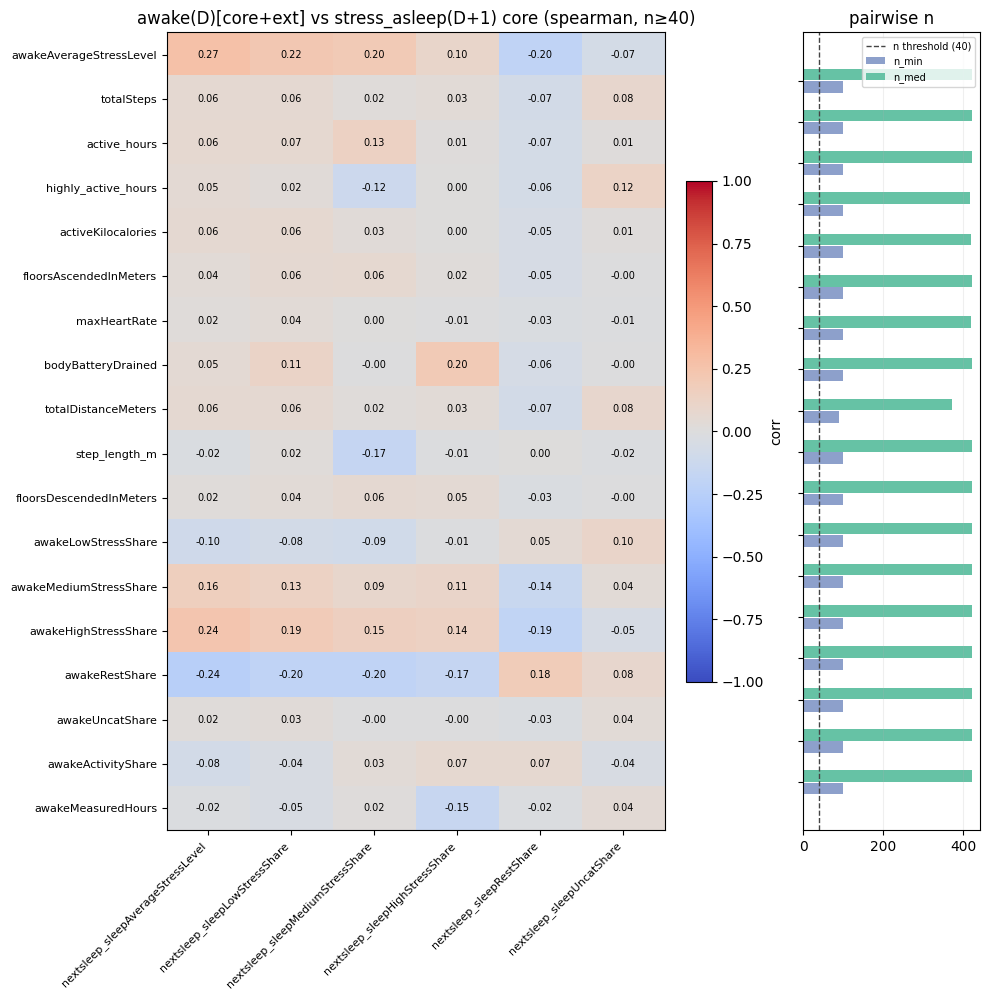

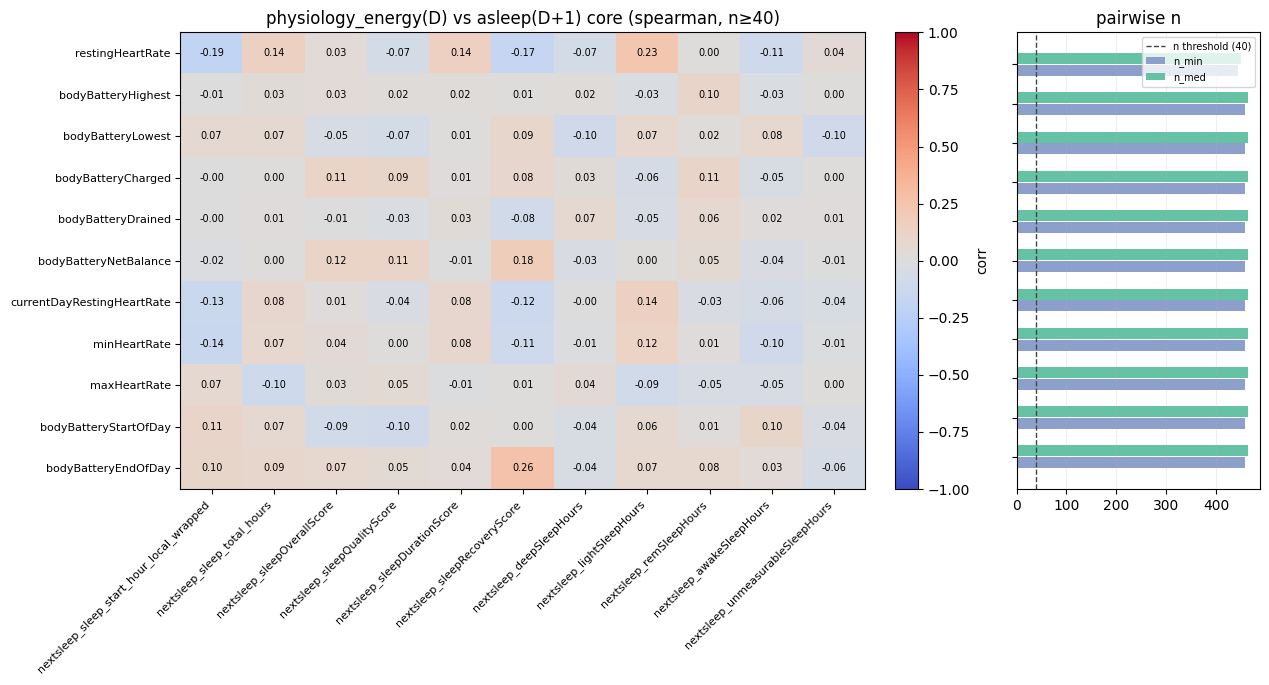

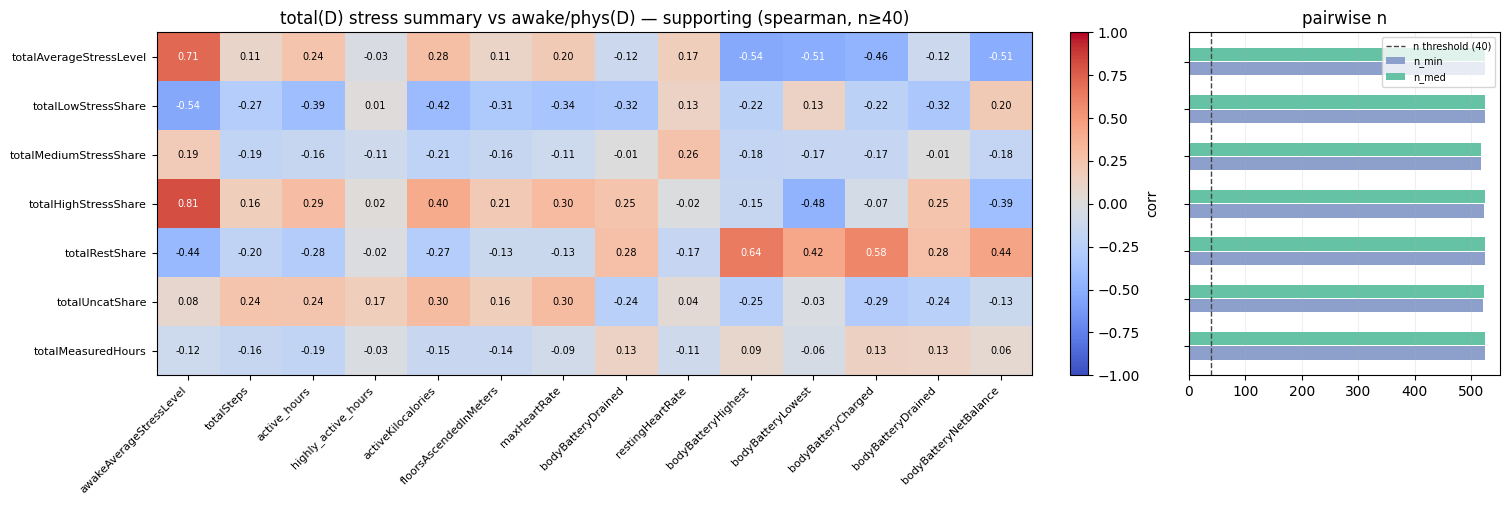

             row_metric                               col_metric      corr     n  abs_corr
    highly_active_hours nextsleep_sleep_start_hour_local_wrapped  0.331511 465.0  0.331511
awakeAverageStressLevel             nextsleep_sleepRecoveryScore -0.284973 464.0  0.284973
awakeAverageStressLevel        nextsleep_sleepAverageStressLevel  0.266123 451.0  0.266123
   awakeHighStressShare             nextsleep_sleepRecoveryScore -0.253274 463.0  0.253274
         awakeRestShare        nextsleep_sleepAverageStressLevel -0.244793 445.0  0.244793
         awakeRestShare             nextsleep_sleepRecoveryScore  0.244788 458.0  0.244788
   awakeHighStressShare        nextsleep_sleepAverageStressLevel  0.238799 450.0  0.238799
    highly_active_hours                  nextsleep_remSleepHours -0.223482 458.0  0.223482
awakeAverageStressLevel            nextsleep_sleepLowStressShare  0.220378 445.0  0.220378
awakeAverageStressLevel                 nextsleep_sleepRestShare -0.201909 451.0  0.201909

In [10]:
# Correlation matrix feature groups (curated, grouped, core vs extended)
corr_groups = {
    'asleep_core_D': [
        # core timing + quantity + scores
        'sleep_start_hour_local_wrapped',
        'sleep_total_hours',
        # all main sleep scores together
        'sleepOverallScore',
        'sleepQualityScore',
        'sleepDurationScore',
        'sleepRecoveryScore',
        # all main sleep stage hours together
        'deepSleepHours',
        'lightSleepHours',
        'remSleepHours',
        'awakeSleepHours',
        'unmeasurableSleepHours',
    ],
    'asleep_extended_D': [
        'sleepRespirationAverage',
        'sleepRespirationLowest',
        'sleepRespirationHighest',
        'sleepSpo2Average',
        'sleepSpo2Lowest',
        'sleepSpo2AverageHR',
    ],
    'stress_asleep_core_D': [
        'sleepAverageStressLevel',
        'sleepLowStressShare',
        'sleepMediumStressShare',
        'sleepHighStressShare',
        'sleepRestShare',
        'sleepUncatShare',
    ],
    'stress_asleep_extended_D': [
        'sleepMeasuredHours',
        'sleepActivityHours',
        'sleepLowStressHours',
        'sleepMediumStressHours',
        'sleepHighStressHours',
        'sleepRestHours',
        'sleepUncatHours',
    ],
    'awake_core_D': [
        'awakeAverageStressLevel',
        'totalSteps',
        'active_hours',
        'highly_active_hours',
        'activeKilocalories',
        'floorsAscendedInMeters',
        'maxHeartRate',
        'bodyBatteryDrained',
    ],
    'awake_extended_D': [
        'totalDistanceMeters',
        'step_length_m',
        'floorsDescendedInMeters',
        'awakeLowStressShare',
        'awakeMediumStressShare',
        'awakeHighStressShare',
        'awakeRestShare',
        'awakeUncatShare',
        'awakeActivityShare',
        'awakeMeasuredHours',
    ],
    'physiology_energy_core_D': [
        'restingHeartRate',
        'bodyBatteryHighest',
        'bodyBatteryLowest',
        'bodyBatteryCharged',
        'bodyBatteryDrained',
        'bodyBatteryNetBalance',
    ],
    'physiology_energy_extended_D': [
        'currentDayRestingHeartRate',
        'minHeartRate',
        'maxHeartRate',
        'bodyBatteryStartOfDay',
        'bodyBatteryEndOfDay',
    ],
    'stress_total_extended_D': [
        'totalAverageStressLevel',
        'totalLowStressShare',
        'totalMediumStressShare',
        'totalHighStressShare',
        'totalRestShare',
        'totalUncatShare',
        'totalMeasuredHours',
    ],
}


# Show a compact registry/availability table for the matrix feature groups.
registry_rows = []
for group_name, cols in corr_groups.items():
    if group_name.startswith(('asleep_', 'stress_asleep_')):
        frame_name, frame_ref = 'df_sleep_e', df_sleep_e
    elif group_name.startswith(('awake_', 'physiology_energy_', 'stress_total_')):
        frame_name, frame_ref = 'df_strict_e', df_strict_e
    else:
        frame_name, frame_ref = 'unknown', df_strict_e
    for col in cols:
        registry_rows.append({
            'group': group_name,
            'frame': frame_name,
            'metric': col,
            'present': col in frame_ref.columns,
        })
corr_registry = pd.DataFrame(registry_rows)
_safe_display_any(
    corr_registry.groupby(['group', 'frame'], as_index=False).agg(n_metrics=('metric', 'count'), n_present=('present', 'sum'))
)

# Prefix helper for next-sleep matrix columns.
def _prefixed_existing(frame: pd.DataFrame, cols: list[str], prefix: str) -> list[str]:
    out = []
    for c in cols:
        pc = f'{prefix}{c}'
        if pc in frame.columns:
            out.append(pc)
    return out

asleep_core_D = corr_groups['asleep_core_D']
asleep_ext_D = corr_groups['asleep_extended_D']
asleep_stress_core_D = corr_groups['stress_asleep_core_D']
asleep_stress_ext_D = corr_groups['stress_asleep_extended_D']
awake_core_D = corr_groups['awake_core_D']
awake_ext_D = corr_groups['awake_extended_D']
phys_core_D = corr_groups['physiology_energy_core_D']
phys_ext_D = corr_groups['physiology_energy_extended_D']
stress_total_ext_D = corr_groups['stress_total_extended_D']

asleep_core_Dp1 = _prefixed_existing(df_day_nextsleep, asleep_core_D, 'nextsleep_')
asleep_ext_Dp1 = _prefixed_existing(df_day_nextsleep, asleep_ext_D, 'nextsleep_')
asleep_stress_core_Dp1 = _prefixed_existing(df_day_nextsleep, asleep_stress_core_D, 'nextsleep_')

# Core matrix set (readable baseline)
plot_corr_block(df_sleep_e, asleep_core_D, asleep_core_D, title='asleep(D) vs asleep(D) — core', method='spearman', fig_name='corr_asleepD_asleepD_core')
plot_corr_block(df_strict_e, awake_core_D, awake_core_D, title='awake(D) vs awake(D) — core', method='spearman', fig_name='corr_awakeD_awakeD_core')
plot_corr_block(df_sleep_e, asleep_core_D, awake_core_D, title='asleep(D) vs awake(D) — core', method='spearman', fig_name='corr_asleepD_awakeD_core')
plot_corr_block(df_day_nextsleep, awake_core_D, asleep_core_Dp1, title='awake(D) vs asleep(D+1) — core', method='spearman', fig_name='corr_awakeD_asleepDplus1_core')

# Expanded matrix set (grouped, still readable by submatrix)
plot_corr_block(df_sleep_e, asleep_stress_core_D, asleep_core_D, title='stress_asleep(D) vs asleep(D) — core stress', method='spearman', fig_name='corr_stress_asleepD_to_asleepD_core')
plot_corr_block(df_sleep_e, asleep_stress_ext_D, asleep_core_D, title='stress_asleep(D) durations vs asleep(D) — extended', method='spearman', fig_name='corr_stress_asleepD_to_asleepD_ext')
plot_corr_block(df_strict_e, phys_core_D, awake_core_D, title='physiology_energy(D) vs awake(D) — core', method='spearman', fig_name='corr_physD_awakeD_core')
plot_corr_block(df_sleep_e, asleep_core_D, phys_core_D, title='asleep(D) vs physiology_energy(D) — core', method='spearman', fig_name='corr_asleepD_physD_core')
plot_corr_block(df_day_nextsleep, awake_core_D + awake_ext_D, asleep_core_Dp1, title='awake(D)[core+ext] vs asleep(D+1) core', method='spearman', fig_name='corr_awakeD_ext_to_asleepDplus1_core')
plot_corr_block(df_strict_e, awake_core_D + awake_ext_D, awake_core_D + awake_ext_D, title='awake(D) vs awake(D) — core+extended', method='spearman', fig_name='corr_awakeD_awakeD_core_ext')
plot_corr_block(df_sleep_e, asleep_core_D, awake_core_D + awake_ext_D, title='asleep(D) vs awake(D)[core+ext]', method='spearman', fig_name='corr_asleepD_awakeD_core_ext')
plot_corr_block(df_day_nextsleep, awake_core_D + awake_ext_D, asleep_stress_core_Dp1, title='awake(D)[core+ext] vs stress_asleep(D+1) core', method='spearman', fig_name='corr_awakeD_ext_to_stress_asleepDplus1_core')
plot_corr_block(df_day_nextsleep, phys_core_D + phys_ext_D, asleep_core_Dp1, title='physiology_energy(D) vs asleep(D+1) core', method='spearman', fig_name='corr_physD_to_asleepDplus1_core')

# Optional supporting matrix: total stress summary vs core awake/sleep (useful to inspect but lower priority for directionality)
plot_corr_block(df_strict_e, stress_total_ext_D, awake_core_D + phys_core_D, title='total(D) stress summary vs awake/phys(D) — supporting', method='spearman', fig_name='corr_totalD_supporting')



def _top_abs_pairs_from_blocks(
    frame: pd.DataFrame,
    row_cols: list[str],
    col_cols: list[str],
    *,
    method: str = 'spearman',
    min_n: int = 80,
    min_abs_corr: float = 0.15,
    top_k: int = 12,
) -> pd.DataFrame:
    corr, nobs = _pairwise_corr_block(frame, row_cols, col_cols, method=method)
    if corr.empty:
        return pd.DataFrame()

    long = corr.stack().rename('corr').reset_index()
    long.columns = ['row_metric', 'col_metric', 'corr']
    long = long.dropna(subset=['corr'])
    long['n'] = long.apply(lambda r: float(nobs.loc[r['row_metric'], r['col_metric']]), axis=1)
    long['abs_corr'] = long['corr'].abs()

    # If symmetric same-set block, keep only one triangle to avoid duplicate pairs.
    if row_cols == col_cols:
        pos = {c: i for i, c in enumerate(corr.index)}
        long = long[long.apply(lambda r: pos.get(r['row_metric'], -1) < pos.get(r['col_metric'], -1), axis=1)]

    long = long[(long['n'] >= min_n) & (long['abs_corr'] >= min_abs_corr)]
    long = long.sort_values(['abs_corr', 'n'], ascending=[False, False]).head(top_k)
    return long.reset_index(drop=True)


# Shortlist strongest day->next-night pairs from the expanded awake set.
shortlist_day_to_nextsleep = _top_abs_pairs_from_blocks(
    df_day_nextsleep,
    awake_core_D + awake_ext_D,
    asleep_core_Dp1 + asleep_stress_core_Dp1,
    method='spearman',
    min_n=80,
    min_abs_corr=0.15,
    top_k=12,
)

if shortlist_day_to_nextsleep.empty:
    print('No day->next-night pairs passed shortlist thresholds.')
else:
    _safe_display_any(shortlist_day_to_nextsleep)
    print('Shortlist is a screening step only. Only pairs re-checked in section 1.7 should appear in final findings.')





### Relationship findings (finalized)

- The strongest directional story in this notebook is **daytime stress carrying into the following night**. `awakeAverageStressLevel (D)` is positively associated with `nextsleep_sleepAverageStressLevel (D+1)` and negatively associated with `nextsleep_sleepRecoveryScore (D+1)`.
- Stress composition matters more than a single average alone: higher `awakeHighStressShare (D)` tends to worsen next-night recovery, while higher `awakeRestShare (D)` tends to improve it.
- `sleep_total_hours -> sleepOverallScore` remains an important structural relationship, but the pair plot suggests a nonlinear optimum band rather than a simple `more sleep = better score` rule.
- Sleep stress is one of the clearest internal score degraders: `sleepAverageStressLevel` tracks worse `sleepOverallScore`, more fragmented sleep, and weaker sleep composition.
- `highly_active_hours` behaves differently from moderate activity: it shows a clearer negative relationship with next-night REM than general activity volume does.
- Correlation matrices are useful for screening, but only the pairs re-checked below are carried into final Stage 2 conclusions.


### 1.7 Targeted validation plots for matrix observations

From the grouped matrices above, retain only the most interpretable and temporally coherent observations for direct validation.

This section is the notebook's **proof layer**: findings below should rely on these direct plots rather than on heatmaps alone.


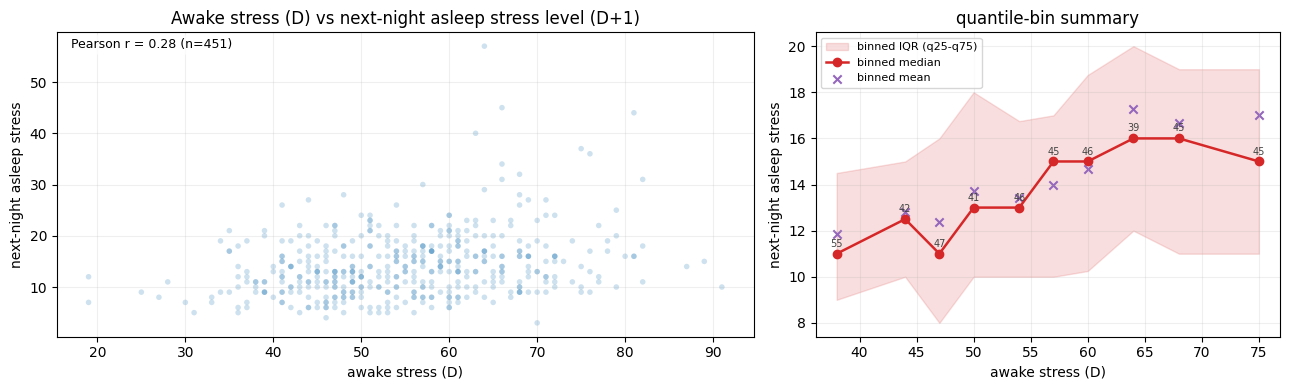

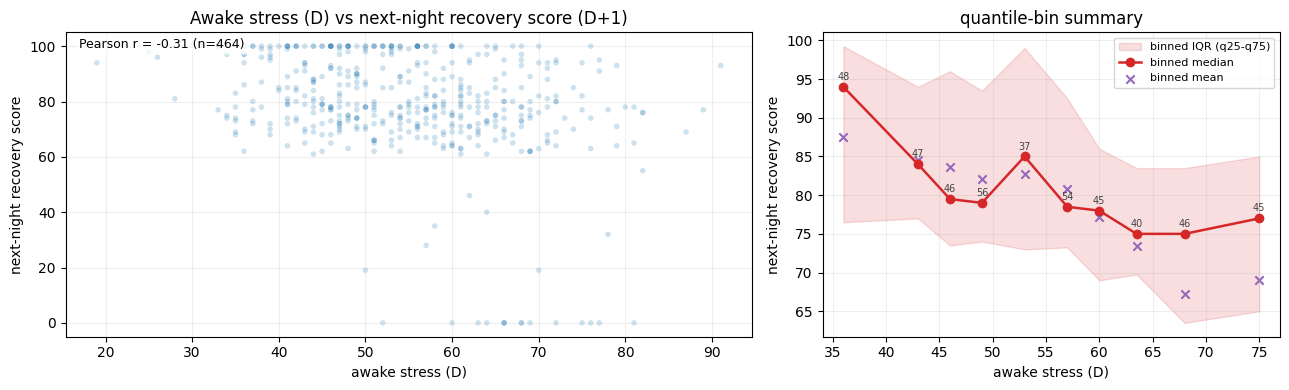

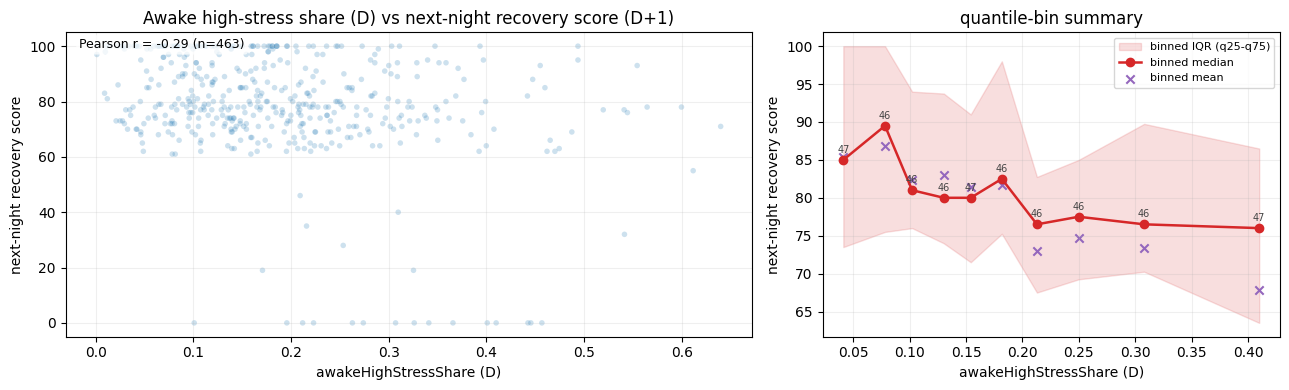

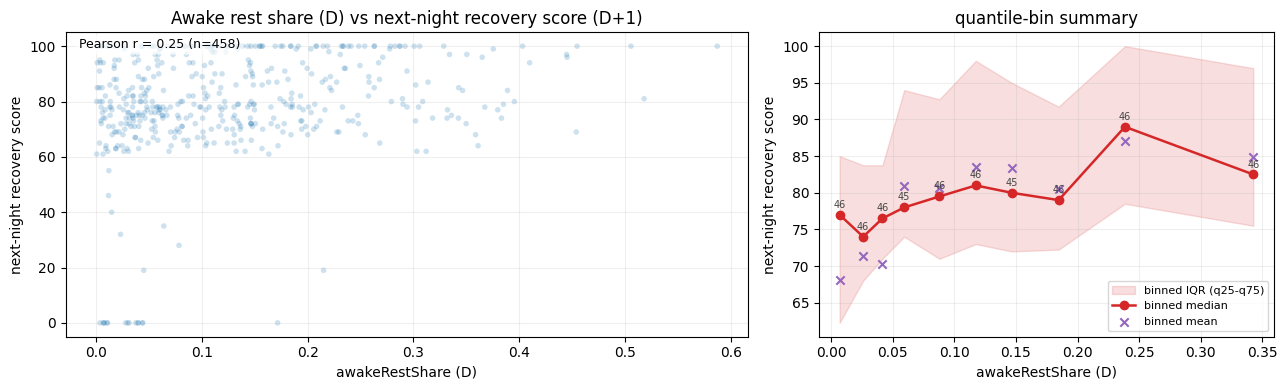

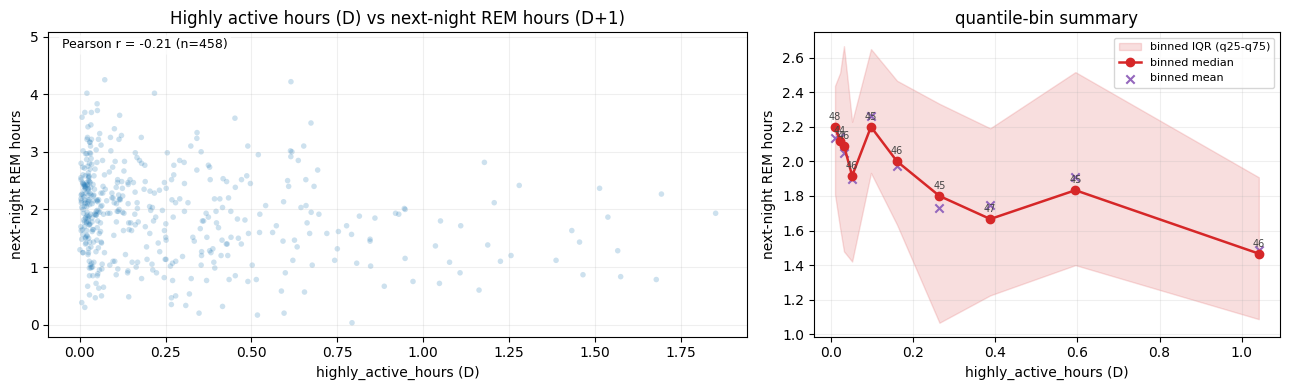

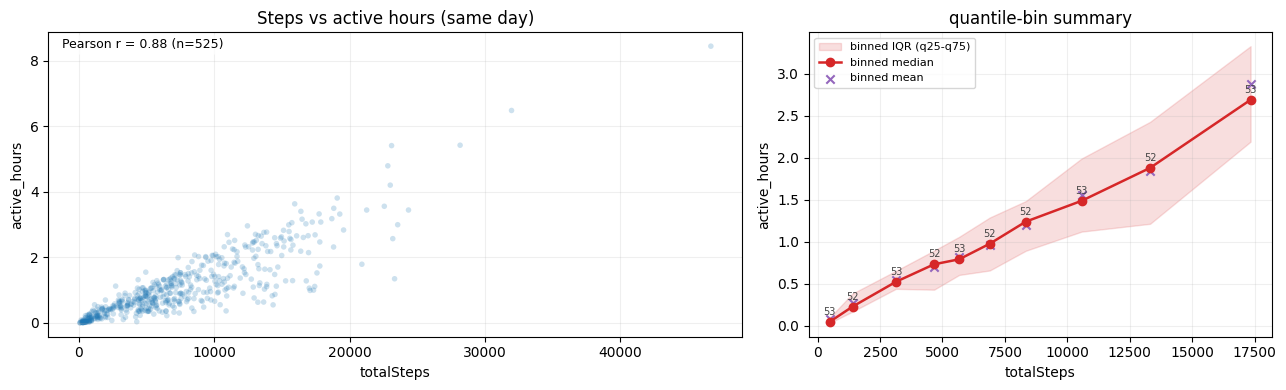

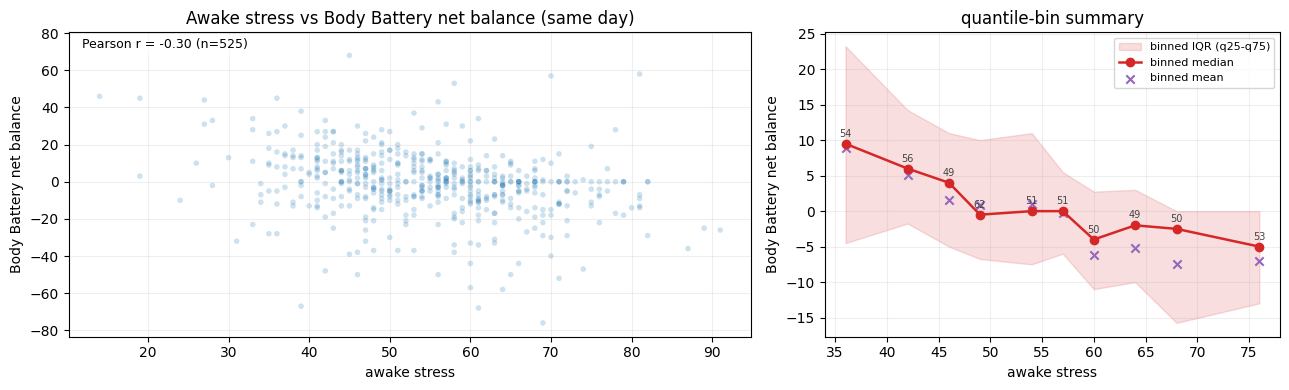

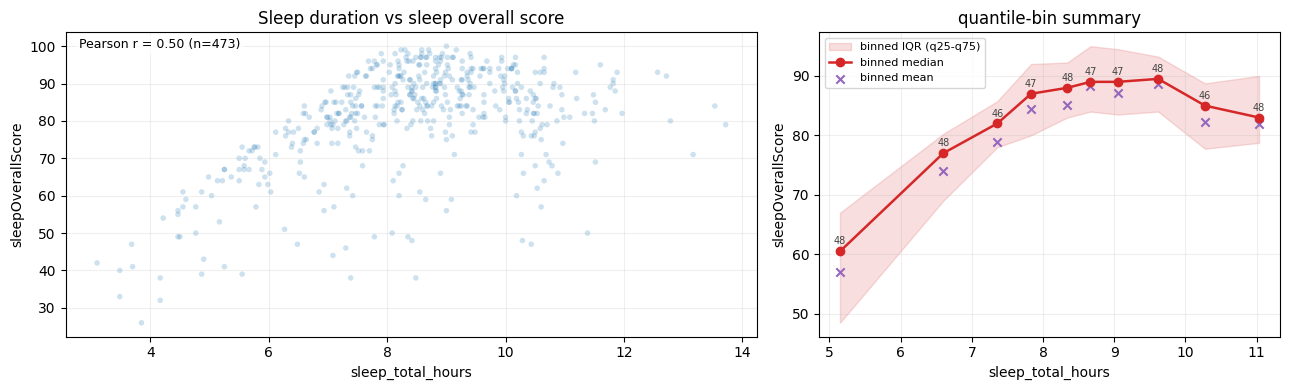

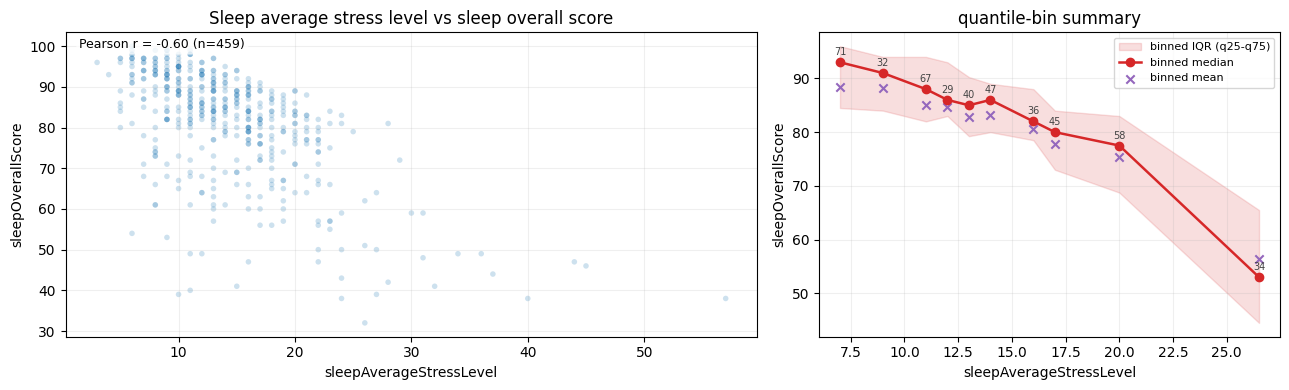

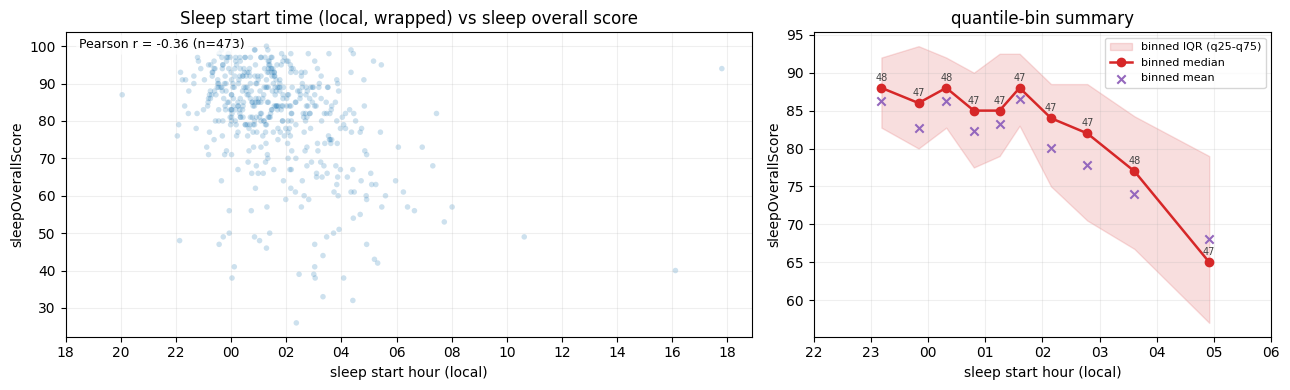

In [11]:
targeted_validation_specs = [
    # Strong day -> next-night relationships
    (df_day_nextsleep, 'awakeAverageStressLevel', 'nextsleep_sleepAverageStressLevel', 'Awake stress (D) vs next-night asleep stress level (D+1)', 'awake stress (D)', 'next-night asleep stress', 'rel_tgt_awake_stress_to_nextsleep_asleep_stress', False, False),
    (df_day_nextsleep, 'awakeAverageStressLevel', 'nextsleep_sleepRecoveryScore', 'Awake stress (D) vs next-night recovery score (D+1)', 'awake stress (D)', 'next-night recovery score', 'rel_tgt_awake_stress_to_nextsleep_recovery', False, False),
    (df_day_nextsleep, 'awakeHighStressShare', 'nextsleep_sleepRecoveryScore', 'Awake high-stress share (D) vs next-night recovery score (D+1)', 'awakeHighStressShare (D)', 'next-night recovery score', 'rel_tgt_awake_high_stress_share_to_nextsleep_recovery', False, False),
    (df_day_nextsleep, 'awakeRestShare', 'nextsleep_sleepRecoveryScore', 'Awake rest share (D) vs next-night recovery score (D+1)', 'awakeRestShare (D)', 'next-night recovery score', 'rel_tgt_awake_rest_share_to_nextsleep_recovery', False, False),
    (df_day_nextsleep, 'highly_active_hours', 'nextsleep_remSleepHours', 'Highly active hours (D) vs next-night REM hours (D+1)', 'highly_active_hours (D)', 'next-night REM hours', 'rel_tgt_highly_active_to_nextsleep_rem', False, False),

    # High-confidence same-day structural checks
    (df_strict_e, 'totalSteps', 'active_hours', 'Steps vs active hours (same day)', 'totalSteps', 'active_hours', 'rel_tgt_steps_vs_active_hours', False, False),
    (df_strict_e, 'awakeAverageStressLevel', 'bodyBatteryNetBalance', 'Awake stress vs Body Battery net balance (same day)', 'awake stress', 'Body Battery net balance', 'rel_tgt_awake_stress_vs_bb_net_balance', False, False),

    # Sleep-internal score interpretation
    (df_sleep_e, 'sleep_total_hours', 'sleepOverallScore', 'Sleep duration vs sleep overall score', 'sleep_total_hours', 'sleepOverallScore', 'rel_tgt_sleep_hours_vs_sleep_score', False, False),
    (df_sleep_e, 'sleepAverageStressLevel', 'sleepOverallScore', 'Sleep average stress level vs sleep overall score', 'sleepAverageStressLevel', 'sleepOverallScore', 'rel_tgt_sleep_stress_vs_sleep_score', False, False),
    (df_sleep_e, 'sleep_start_hour_local_wrapped', 'sleepOverallScore', 'Sleep start time (local, wrapped) vs sleep overall score', 'sleep start hour (local)', 'sleepOverallScore', 'rel_tgt_sleep_start_time_vs_sleep_score', True, False),
]

for frame, xcol, ycol, title, xlabel, ylabel, fig_name, clock_axis_x, clock_axis_y in targeted_validation_specs:
    plot_relationship(
        frame,
        xcol,
        ycol,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        fig_name=fig_name,
        clock_axis_x=clock_axis_x,
        clock_axis_y=clock_axis_y,
    )


## 2. Block F — Artifact and anomaly review

Question: **Which suspicious days are likely artifacts / partial coverage, and which are unusual but still plausible?**

This section stays intentionally lightweight: it reviews the **union of suspicious-day exports**, collapses them to unique dates, assigns a compact artifact taxonomy, and highlights representative cases. The goal is not a forensic subsystem, but a pragmatic answer to what was already handled upstream by quality rules versus what still requires analyst judgment.


                          artifact_class  rows  from_suspicious_days  from_artifact_rank  median_stress_hours  median_steps  pct_strict_bad  pct_strict_good  pct_of_candidate_pool
           partial-day battery depletion    22                    10                  13            22.716667        3656.5        4.545455        40.909091              28.205128
               stress-only corrupted day    21                    21                  21                 24.0          <NA>           100.0              0.0              26.923077
            awake-only but plausible day    19                     3                  16            23.933333        3409.0             0.0        84.210526              24.358974
     mixed / needs manual interpretation     9                     9                   0             8.083333          23.0       44.444444              0.0              11.538462
likely no-wear / sparse residual logging     7                     7                   0            

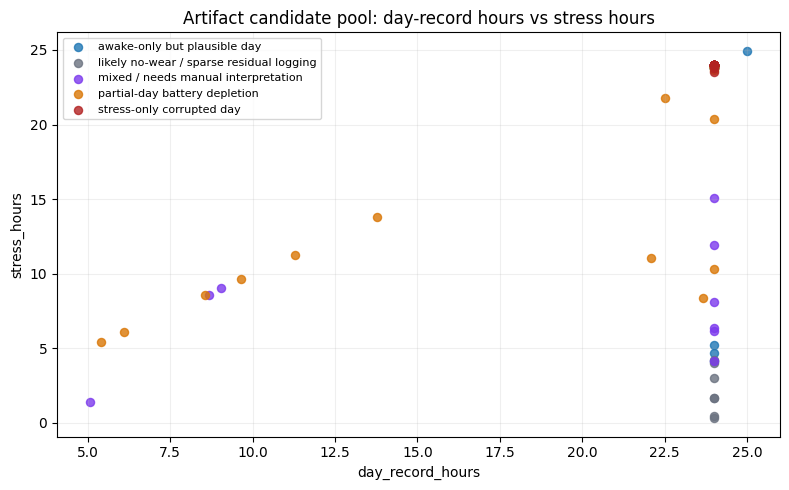

In [12]:
suspicious_dates = suspicious_days[['calendarDate']].copy()
suspicious_dates['calendarDate'] = pd.to_datetime(suspicious_dates['calendarDate'], errors='coerce').dt.normalize()
suspicious_dates['in_suspicious_days'] = True

artifact_ranked_dates = suspicious_days_artifacts[['calendarDate']].copy()
artifact_ranked_dates['calendarDate'] = pd.to_datetime(artifact_ranked_dates['calendarDate'], errors='coerce').dt.normalize()
artifact_ranked_dates['in_suspicious_days_artifacts'] = True

artifact_pool = (
    suspicious_dates.merge(artifact_ranked_dates, on='calendarDate', how='outer')
    .dropna(subset=['calendarDate'])
    .sort_values('calendarDate')
    .drop_duplicates(subset=['calendarDate'])
    .reset_index(drop=True)
)

for flag_col in ['in_suspicious_days', 'in_suspicious_days_artifacts']:
    if flag_col in artifact_pool.columns:
        artifact_pool[flag_col] = artifact_pool[flag_col].fillna(False).astype(bool)

if not artifact_pool.empty:
    df_art_base = df_all.copy()
    df_art_base['calendarDate'] = pd.to_datetime(df_art_base['calendarDate'], errors='coerce').dt.normalize()
    keep_cols = [
        'calendarDate', 'quality_score', 'day_quality_label_strict', 'day_quality_label_loose',
        'corrupted_stress_only_day', 'has_sleep', 'has_hr', 'has_steps',
        'has_bodybattery_start', 'has_bodybattery_end', 'bodybattery_start_without_end',
        'has_stress_duration', 'full_day_stress', 'stress_hours', 'durationInMilliseconds',
        'stressTotalDurationSeconds', 'totalSteps', 'bodyBatteryStartOfDay', 'bodyBatteryEndOfDay',
        'sleepOverallScore',
    ]
    keep_cols = [c for c in keep_cols if c in df_art_base.columns]
    artifact_pool = artifact_pool.merge(df_art_base[keep_cols], on='calendarDate', how='left')
    artifact_pool['day_record_hours'] = pd.to_numeric(artifact_pool.get('durationInMilliseconds'), errors='coerce') / 3_600_000.0
    artifact_pool['stress_hours'] = pd.to_numeric(artifact_pool.get('stressTotalDurationSeconds'), errors='coerce') / 3600.0

    def _artifact_classify(row: pd.Series) -> str:
        if bool(row.get('corrupted_stress_only_day', False)):
            return 'stress-only corrupted day'
        if bool(row.get('bodybattery_start_without_end', False)):
            return 'partial-day battery depletion'
        if (
            (not bool(row.get('has_hr', False)))
            and (not bool(row.get('has_steps', False)))
            and (not bool(row.get('has_sleep', False)))
            and pd.notna(row.get('stress_hours'))
            and float(row.get('stress_hours')) < 6.0
        ):
            return 'likely no-wear / sparse residual logging'
        if (
            bool(row.get('has_hr', False))
            and bool(row.get('has_steps', False))
            and (not bool(row.get('has_sleep', False)))
            and bool(row.get('has_bodybattery_end', False))
        ):
            return 'awake-only but plausible day'
        return 'mixed / needs manual interpretation'

    artifact_pool['artifact_class'] = artifact_pool.apply(_artifact_classify, axis=1)

    artifact_class_summary = (
        artifact_pool.groupby('artifact_class', as_index=False)
        .agg(
            rows=('calendarDate', 'count'),
            from_suspicious_days=('in_suspicious_days', 'sum'),
            from_artifact_rank=('in_suspicious_days_artifacts', 'sum'),
            median_stress_hours=('stress_hours', 'median'),
            median_steps=('totalSteps', 'median'),
            pct_strict_bad=('day_quality_label_strict', lambda s: 100.0 * s.eq('bad').mean()),
            pct_strict_good=('day_quality_label_strict', lambda s: 100.0 * s.eq('good').mean()),
        )
        .sort_values('rows', ascending=False)
        .reset_index(drop=True)
    )
    artifact_class_summary['pct_of_candidate_pool'] = 100.0 * artifact_class_summary['rows'] / len(artifact_pool)
    _safe_display_any(artifact_class_summary)

    plausible_days = artifact_pool[
        artifact_pool['artifact_class'].isin(['awake-only but plausible day', 'partial-day battery depletion'])
        & artifact_pool['day_quality_label_strict'].isin(['good', 'partial'])
    ][[
        'calendarDate', 'artifact_class', 'quality_score', 'day_quality_label_strict',
        'stress_hours', 'totalSteps', 'bodyBatteryStartOfDay', 'bodyBatteryEndOfDay', 'sleepOverallScore'
    ]].head(8)
    _safe_display_any(plausible_days)

    representative_cases = pd.DataFrame([
        {'calendarDate': pd.Timestamp('2024-02-26'), 'interpretation': 'Canonical stress-only corrupted run: full-day stress logging with no corroborating signals.'},
        {'calendarDate': pd.Timestamp('2023-06-01'), 'interpretation': 'Likely battery depletion before end-of-day: start present, end missing, but the rest of the day looks otherwise real.'},
        {'calendarDate': pd.Timestamp('2023-07-11'), 'interpretation': 'Awake-only but plausible day: daytime coverage is real, but there is no sleep row for that date.'},
        {'calendarDate': pd.Timestamp('2024-02-04'), 'interpretation': 'Sparse residual logging / likely no-wear: almost no corroborating signals and very low stress duration.'},
        {'calendarDate': pd.Timestamp('2024-01-12'), 'interpretation': 'Mixed partial day: some corroborating signals exist, but coverage is too incomplete for confident interpretation.'},
    ])
    artifact_case_table = representative_cases.merge(
        artifact_pool[[
            'calendarDate', 'artifact_class', 'quality_score', 'day_quality_label_strict',
            'stress_hours', 'day_record_hours', 'totalSteps', 'bodyBatteryStartOfDay', 'bodyBatteryEndOfDay', 'sleepOverallScore'
        ]],
        on='calendarDate',
        how='left',
    )
    _safe_display_any(artifact_case_table)

    colors = {
        'stress-only corrupted day': '#b22222',
        'partial-day battery depletion': '#d97706',
        'awake-only but plausible day': '#1f77b4',
        'likely no-wear / sparse residual logging': '#6b7280',
        'mixed / needs manual interpretation': '#7c3aed',
    }
    fig, ax = plt.subplots(figsize=(8, 5))
    for label, sub in artifact_pool.groupby('artifact_class', observed=True):
        ax.scatter(
            sub['day_record_hours'],
            sub['stress_hours'],
            s=34,
            alpha=0.8,
            color=colors.get(label, '#555555'),
            label=label,
        )
    ax.set_title('Artifact candidate pool: day-record hours vs stress hours')
    ax.set_xlabel('day_record_hours')
    ax.set_ylabel('stress_hours')
    ax.grid(alpha=0.2)
    ax.legend(fontsize=8, loc='best')
    fig.tight_layout()
    maybe_savefig(fig, 'artifact_candidate_pool_record_vs_stress_hours', save_figs=SAVE_FIGS, fig_dir=FIG_DIR, dpi=DPI, fmt=FIG_FMT)
    plt.show()
    plt.close(fig)
else:
    print('Artifact review skipped: suspicious-day inputs are empty.')


### Artifact review findings (finalized)

- The artifact candidate pool contains **78 unique dates** after collapsing overlaps between `suspicious_days.csv` and `suspicious_days_artifacts.csv`.
- Five recurring patterns appear in that pool:
  - `partial-day battery depletion`: **22** dates
  - `stress-only corrupted day`: **21** dates
  - `awake-only but plausible day`: **19** dates
  - `mixed / needs manual interpretation`: **9** dates
  - `likely no-wear / sparse residual logging`: **7** dates
- Missing sleep alone is **not** enough to call a day corrupted: the `awake-only but plausible` cluster still carries daytime HR / steps / Body Battery evidence and is mostly labeled `good` or `partial`.
- `corrupted_stress_only_day` remains the cleanest artifact signature because it combines near-full-day stress logging with no corroborating physiological or activity signals.
- This review supports the current pipeline design: hard artifact signatures are already pushed toward `bad`, while a smaller boundary zone remains for analyst judgment rather than automatic deletion.


## 3. Block G — Findings, hypotheses, limitations

This section closes Stage 2. Only observations that remain interpretable after direct validation and artifact review are kept here.


### Findings (final synthesis from Blocks E/F)

- **Daytime stress carries into the following night**: `awakeAverageStressLevel (D)` is positively associated with `nextsleep_sleepAverageStressLevel (D+1)` (Pearson ≈ 0.28, Spearman ≈ 0.27; `n≈451`).
- **Daytime stress also degrades overnight recovery**: `awakeAverageStressLevel (D)` vs `nextsleep_sleepRecoveryScore (D+1)` is clearly negative (Pearson ≈ -0.31, Spearman ≈ -0.29; `n≈464`).
- **Stress composition matters**: `awakeHighStressShare (D)` is negatively associated with next-night recovery, while `awakeRestShare (D)` is positively associated with it. The qualitative makeup of the day matters, not only the average level.
- **Sleep score has an optimum-duration pattern**, not a simple monotonic trend: the pair plot of `sleep_total_hours` vs `sleepOverallScore` shows a broad mid-range band performing best.
- **Sleep stress is a strong internal score degrader**: `sleepAverageStressLevel` has one of the clearest inverse relationships with `sleepOverallScore` (Pearson ≈ -0.60, Spearman ≈ -0.56; `n≈459`).
- **Later sleep onset tends to coincide with lower sleep score** after wrapped local-time correction (`sleep_start_hour_local_wrapped` vs `sleepOverallScore`, Pearson ≈ -0.36; `n≈473`). Timing is not the only factor, but it is not negligible either.
- **Very intense activity behaves differently from ordinary activity**: `highly_active_hours (D)` is associated with lower next-night REM, whereas the much stronger same-day `totalSteps` vs `active_hours` relation mostly reflects walking-driven general activity.
- **Body Battery behaves consistently with stress burden**: higher daytime stress is associated with more negative `bodyBatteryNetBalance`, which makes Garmin's energy metric useful descriptively even if it remains model-derived.
- **Suspicious days are heterogeneous**: some are clearly corrupted (`stress-only` runs), while others remain plausible partial-coverage days. This justifies keeping both upstream quality rules and downstream analyst review.

### Hypotheses (next-step candidates, still observational)

- **Stress inertia hypothesis**: elevated daytime stress propagates into higher night stress and weaker overnight recovery.
- **Recovery tradeoff hypothesis**: very high-intensity activity can coexist with lower REM / higher fragmentation proxies, even when total daytime activity looks healthy.
- **Sleep-duration optimum hypothesis**: this user appears to have an individual score-maximizing sleep-duration band rather than a `more is always better` relationship.
- **Rest-share buffer hypothesis**: a higher daytime rest / low-stress share protects next-night recovery metrics.
- **Timing confounding hypothesis**: later sleep onset matters, but part of its apparent effect is likely entangled with daytime stress/activity composition.

### Limitations

- Single-subject observational dataset (`N=1`); no causal identification.
- Garmin-derived scores (stress, sleep score, Body Battery) are wearable/model proxies, not clinical ground truth.
- Coverage gaps, charging periods, and off-wrist artifacts can still shape daily aggregates despite upstream quality labeling.
- Circular-time variables (sleep start) require wrapped handling; linear correlation remains an imperfect summary for clock time.
- Matrix screening creates multiple-comparison risk; only visually re-checked pairs should drive conclusions.
- Results depend on Garmin feature engineering and device-side aggregation assumptions, not only on raw sensor behavior.
